```
import Pyro4.util
try:
    [run your usual rfsoc experiment here]
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))
```

In [1]:
# %matplotlib widget
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [4]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
expt_path=os.path.join(os.getcwd(),'data', 'data_231127')
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_231127


In [7]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [9]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# Qubit/resonator to probe

In [13]:
qubit_i = 0

# RFSoC Calibration

In [14]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=0.9,
    # gain=30000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3445.5877321124563, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.2353064588515, 0, 4766.264226603061, 4384.890337223246], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5892.65, 5152.0], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [21052, 25413, 2705, 2516], 'sigma': [0.02, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107,

  0%|          | 0/1000 [00:00<?, ?it/s]

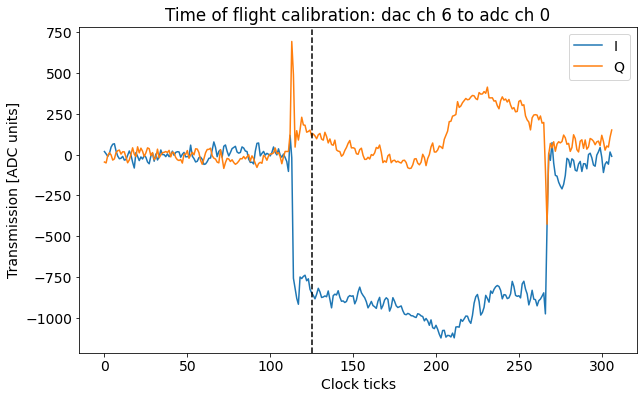

In [15]:
tof.display(adc_trig_offset=125)

In [14]:
tof.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_adc_trig_offset_calibration_qubit2.h5


# Resonator spectroscopy

## Single tone (resonator) spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state: sweep readout pulse frequency and look for the frequency with the maximum measured amplitude.

The resonator frequency should be stored in the parameter <code>cfg.device.readouti.frequency</code>.

Note that harmonics of the clock frequency (6144 MHz) will show up as "infinitely"  narrow peaks!


In [85]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 2.0 # MHz
npts = 200
# arduino.set_voltage(channel=4, voltage=0.0104)
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span, # resonator frequency to be mixed up [MHz]
    # start=-807-span/2, # resonator frequency to be mixed up [MHz]
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.75*span,
    # start=rspec.cfg.device.readout.frequency[qubit_i]-0.25*span,
    # start=0,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number experiments stepping from start
    reps=500, # Number averages per point
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)

rspec.cfg.device.readout.gain[qubit_i] = 0.085
# rspec.cfg.device.readout.frequency[qubit_i] = 822.2138666666668

rspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us]
# rspec.cfg.device.readout.readout_length = 5

print(rspec.cfg)
rspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4117.481175159228, 3450.7895590725893, 4767.359704214145, 4399.091470915781], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [21, 88, 33, 50], 'pulses': {'pi_ge': {'gain': [27226, 24945, 2705, 2646], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107, 1859, 1669], 'sigma': [0.015, 0.04686378155276164, 0.022312951557475664, 0.015], 'type': '

  0%|          | 0/200 [00:00<?, ?it/s]

[93.15733333000003, 5000, 1000, 0, 37.75143641715164, 110.38350957845164, -0.14860683257255794]
[ 9.31896233e+01  4.43672840e+02  5.62545650e+04 -7.28721188e-02
  3.98431494e+03  8.41475814e+01  2.32869523e+00]
5925.0
950
93.1896232668405

Freq with minimum transmission: 93.16233333000001
Freq with maximum transmission: 93.98233333
From fit:
	f0: 6968.1896232668405
	Qi: 443.6728396700238
	Qe: 56254.56496887902
	Q0: 440.20102826513414
	kappa [MHz]: 15.829562349567896
	phi [radians]: -0.07287211879771116


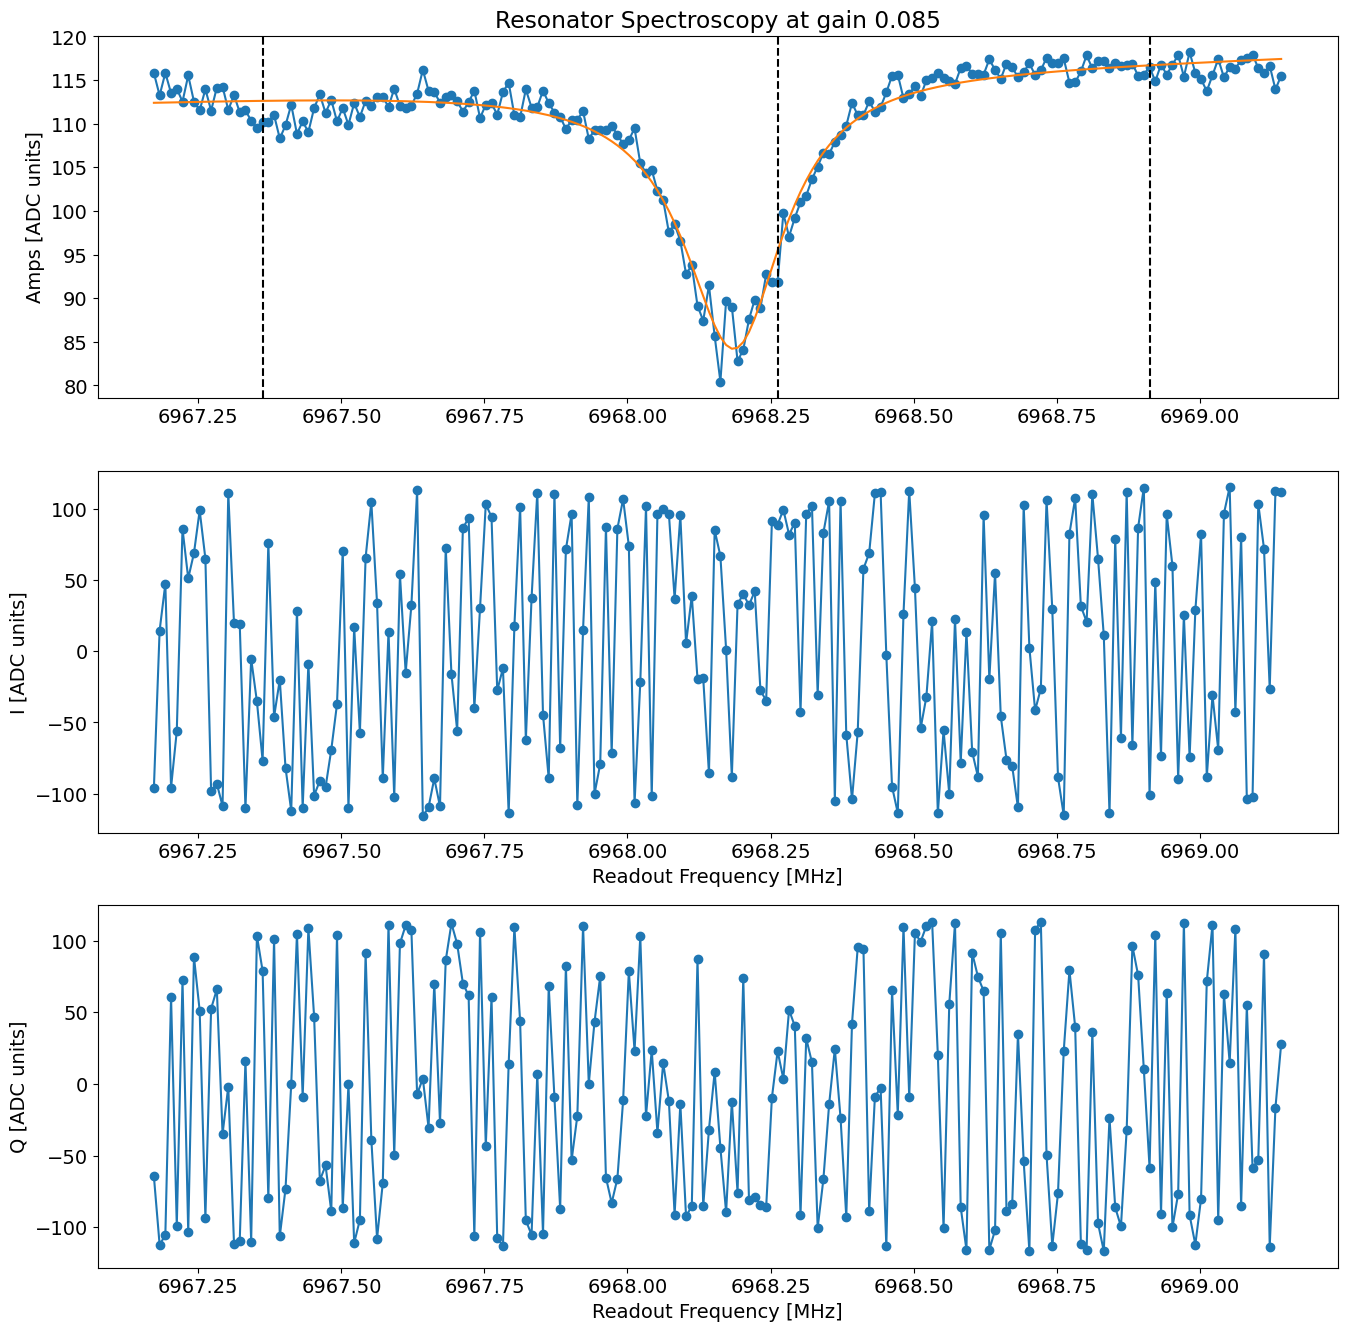

In [86]:
# # TESTING
# rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# # temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit1.h5')
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit0.h5')
# i_gain = np.argmin(np.abs(temp_data['gainpts']-30))
# temp_data['amps'] = temp_data['amps'][i_gain][80:]
# temp_data['xpts'] = temp_data['xpts'][80:]
# data = rspec.analyze(data=temp_data, fit=True)
# rspec.display(data=data, fit=True)

rspec.analyze(fit=True, findpeaks=False)
rspec.display(fit=True, findpeaks=False)

In [117]:
rspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_ResonatorSpectroscopy.h5


## Power sweep resonator spectroscopy

Repeat resonator spectroscopy at a range of powers to check that resonator frequency shifts at low powers. (Check qubit is alive.)

Use this experiment to determine the appropriate resonator gain, which should be stored in <code>cfg.device.readout.gain</code>


In [71]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5.0
npts_f = 400

span_gain = 0.8
npts_gain = 8

rpowspec.cfg.expt = dict(
    # start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.75, # sweep frequency [MHz]
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=rpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    # start_gain=0.001,
    start_gain=0.2,
    step_gain=span_gain/npts_gain, # Gain step size
    # step_gain=0, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=500, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qubit=qubit_i,
)
rpowspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 5

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4125.896624486673, 3452.4896245260456, 4780.416037811193, 4395.282433405918], 'f_ef': [3900.453831863158, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [60, 57, 55, 50], 'pulses': {'pi_ge': {'gain': [29351, 26882, 3021, 2572], 'sigma': [0.015, 0.1, 0.020886833661091352, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20742, 26000, 1633, 1669], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_Z

  0%|          | 0/9 [00:00<?, ?it/s]

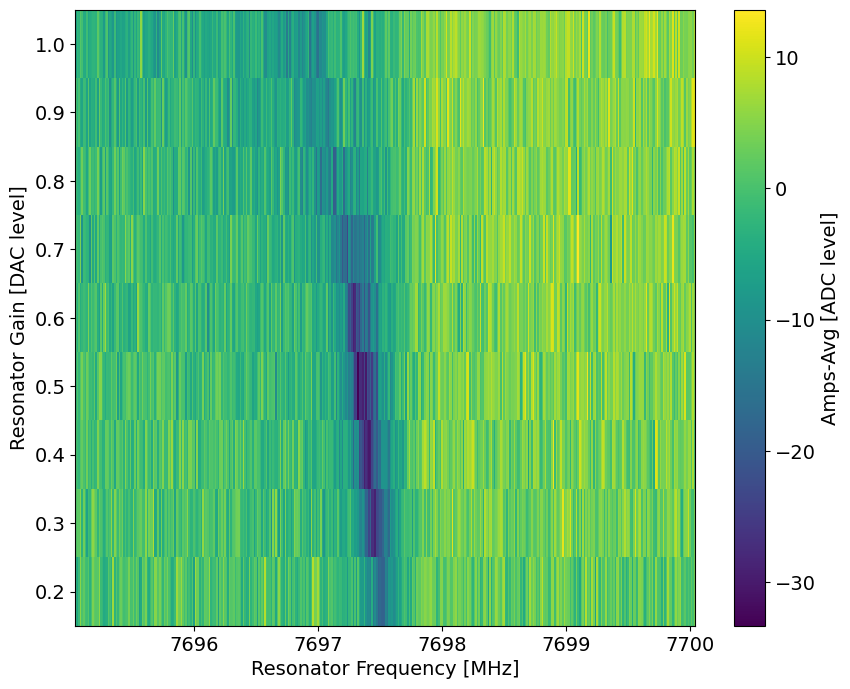

1.0


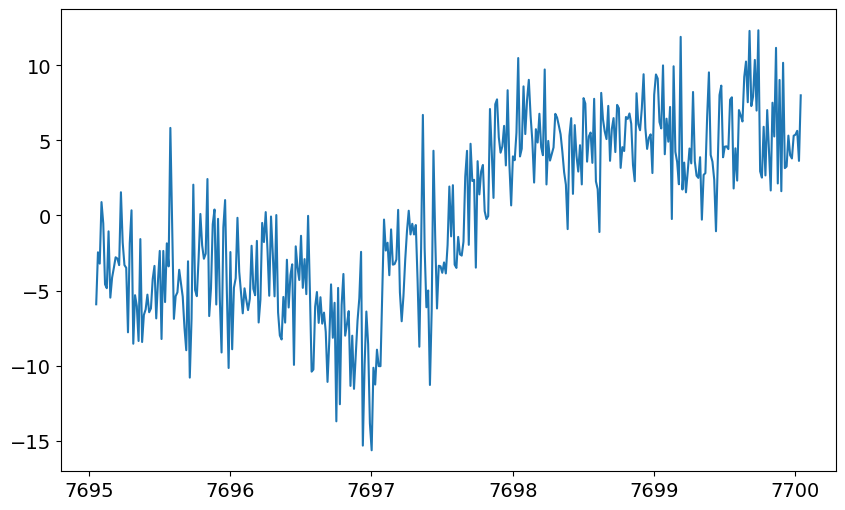

In [72]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False)

In [97]:
rpowspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00000_power_sweep_resonator_spectroscopy_qubit2.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge by driving at resonator frequency and sweeping qubit frequency.

Qubit frequency should be stored in <code>cfg.qubiti.f_ge</code>.

In [111]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 15
npts = 250

# span = 50
# npts = 300

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # resonator frequency to be mixed up [MHz]
    # start=qspec.cfg.device.qubit.f_ge[qubit_i]-0.95*span, # resonator frequency to be mixed up [MHz]
    # start=4780,
    step=span/npts, # min step ~1 MHz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    # length=1, # Qubit probe constant pulse length [us]
    # gain=200, # Qubit pulse gain
    length=1, # Qubit probe constant pulse length [us]
    gain=2000, # Qubit pulse gain
    # pulse_type='const',
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
# qspec.cfg.device.readout.frequency[qubit_i] = -813.508 # Wait time between experiments [us]
# qspec.cfg.device.readout.gain[qubit_i] = 0.015

print(qspec.cfg)

qspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [29572, 24945, 2705, 2516], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107, 1859, 1703], 'sigma': [0.015, 0.04686378155276164, 0.022312951557475664, 0.015], 'type': '

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3450.1132076124936, HWHM 0.7715363498284239
Found peak in I at [MHz] 3444.24895963109, HWHM 0.2662426814774434
Found peak in Q at [MHz] 3450.157266573735, HWHM 0.6793917787389363


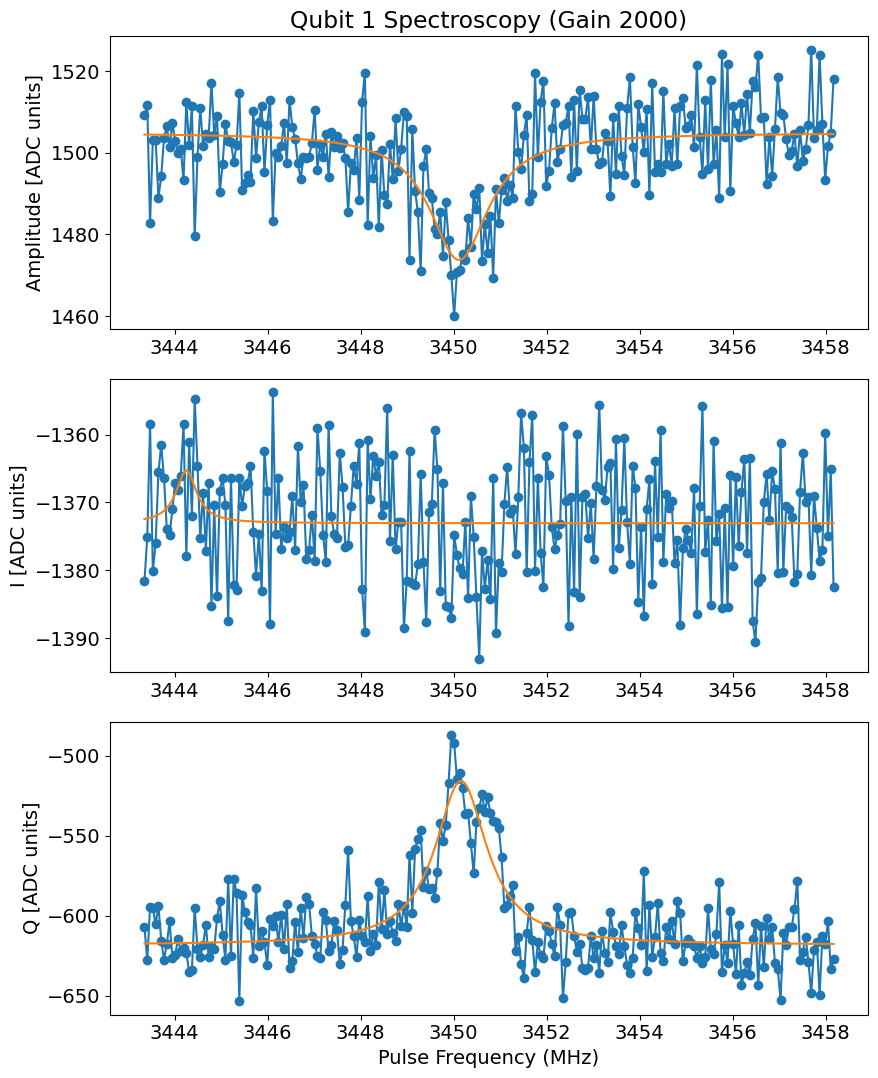

In [112]:
# # TESTING
# qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit1.h5')
# temp_data['avgi'] = temp_data['amps']
# data = qspec.analyze(data=temp_data, fit=True)
# qspec.display(data=data, fit=True)

qspec.analyze(fit=True, signs=[1, -1, 1])
qspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00004_qubit_spectroscopy_qubit3.h5


## Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.


In [87]:
soc.cycles2us(1, gen_ch=0)

0.0023251488095238095

In [62]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabi.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=51,
    reps=2000,
    # gain=10000, # qubit gain [DAC units],
    gain=lengthrabi.cfg.device.qubit.pulses.pi_ge.gain[qubit_i],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # qubits=[3,1],
)
# lengthrabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabi.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.338723559245, 4782.994651953712, 4396.915066710553], 'f_Q1_ZZ': [3452.057926470567, 0, 3456.1893267454375, 3456.018803727748], 'f_ef': [3902.5097729724093, 3356.650995689788, 4588.124531178372, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5933, 5176], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.222654425229848, -0.12783671475153824, -0.5018857089899029, -5.172752578477684, 0.0, -1.0684162296902286, -1.2142038280621819, -0.23354269077572098, -1.1405468087750705, 0.0, -0.5392270363518037, -0.5256359464065099, -1.2142038280621819, -0.5392270363518037, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 25040, 29830], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 336, 18042, 19207], 'sigma': [0.015, 0.02101, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'

  0%|          | 0/51 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 189.2352, which is out of bounds 0.8777142857142858 to 131.65714285714284. Instead init to 66.26742857142857
Decay from avgi [us] 0.03417968750000001
Pi length from avgi data [us]: 0.004309656387523624
	Pi/2 length from avgi data [us]: 0.002154828193761812

Decay from avgq [us] 0.2986262395253816
Pi length from avgq data [us]: 0.016862633082525478
Pi/2 length from avgq data [us]: 0.008431316541262739


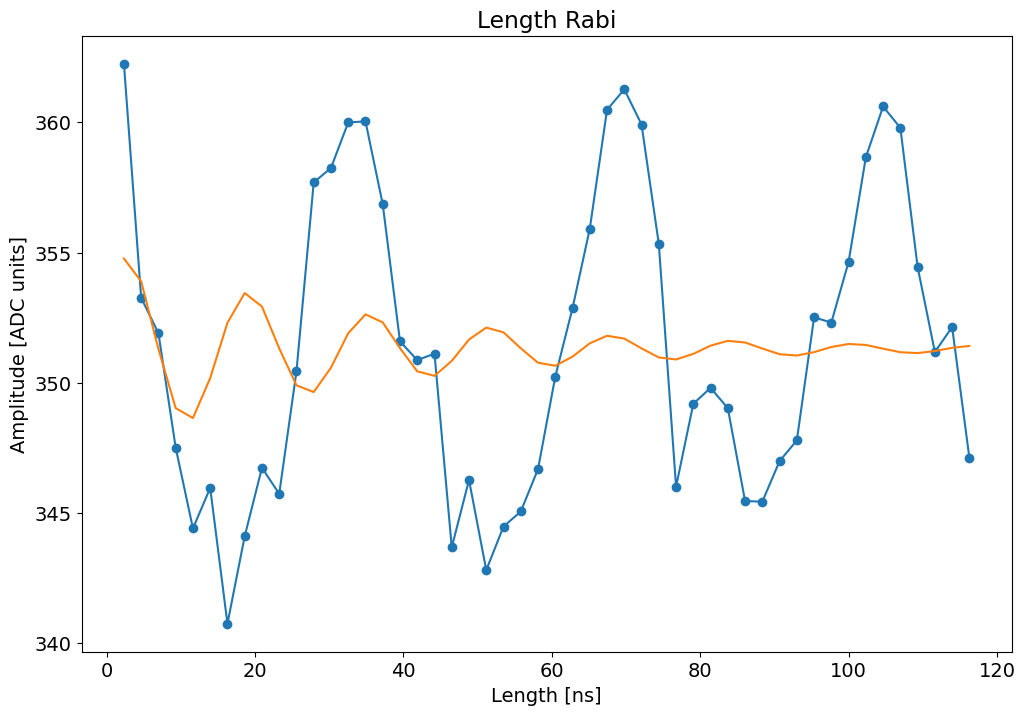

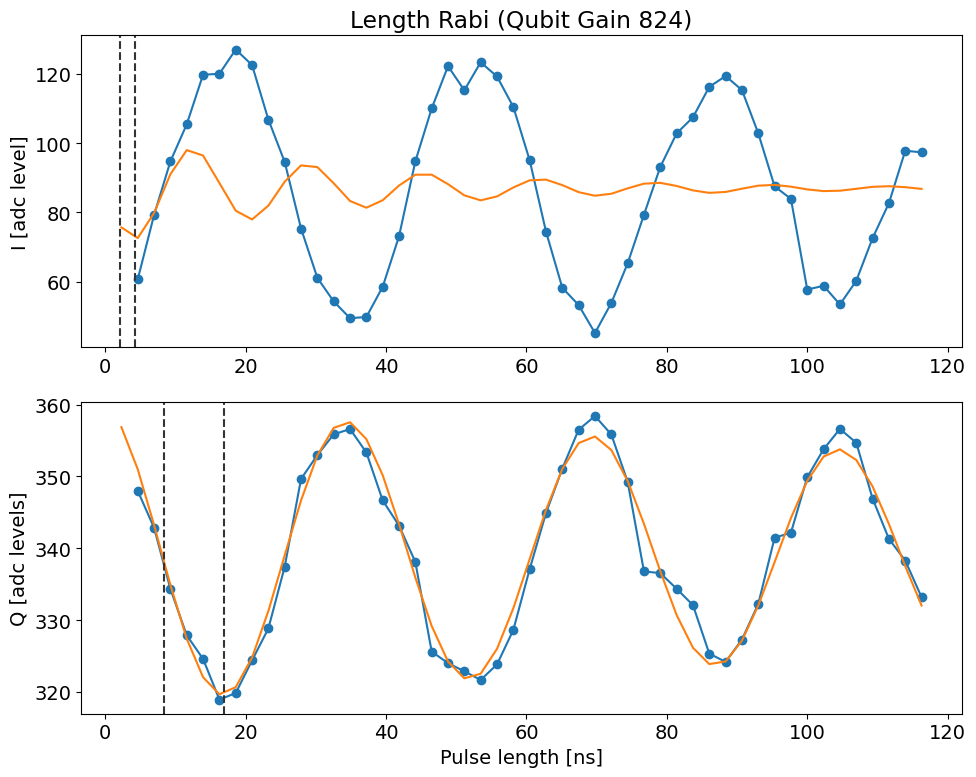

In [63]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

lengthrabi.analyze(fit=True)
lengthrabi.display(fit=True)

In [141]:
lengthrabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_length_rabi_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_221215\\00001_length_rabi_qubit3.h5'

## Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is a Gaussian pulse with sigma set by <code>cfg.device.qubiti.pulses.pi_ge.sigma</code>. We measure the $\pi$ pulse amplitude which are used in subsequent experiments to control the qubit, which should be stored in <code>cfg.device.qubiti.pulses.pi_ge.gain</code>.

QCTRL

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 22.1.0. Latest version is 22.2.0.

Visit ]8;id=139358;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.

In [173]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1764628)

  0%|          | 0/100 [00:00<?, ?it/s]

Fidelity: 0.9807641749181643


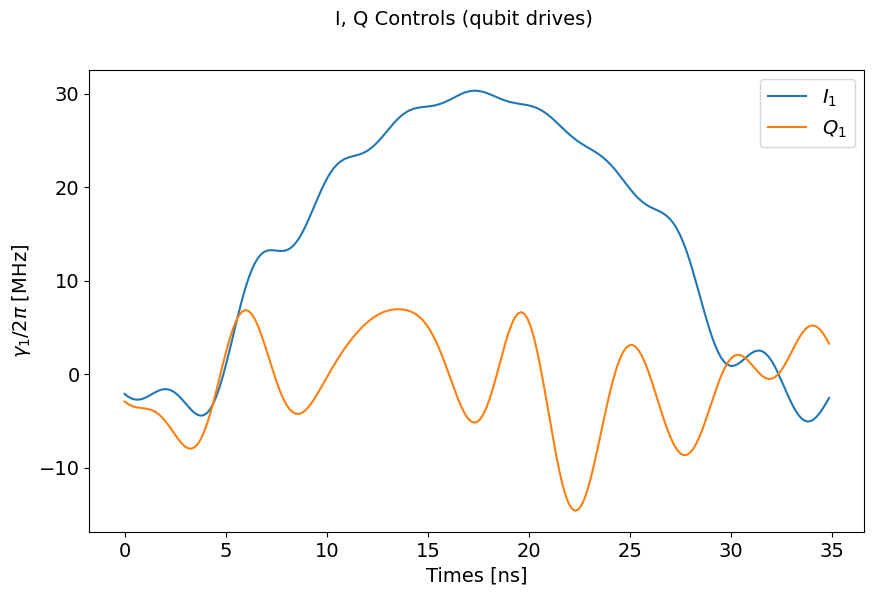

max amplitude (MHz) 33.35044550240938


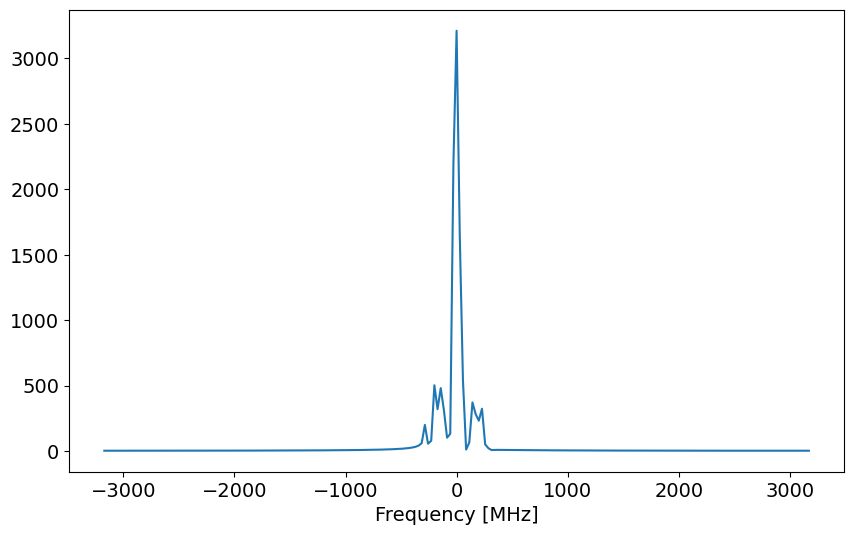

In [175]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])
            # if j==0: I_values_q.append(0.01)
            # else: Q_values_q.append(0.01)

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

# I_values_MHz[0] = 50*np.exp(-(1e3*times_us-150)**2/10**2)
# Q_values_MHz[0] = 0*np.exp(-(times_us)**2/10**2)

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    # plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()
print('max amplitude (MHz)', ymax)

fourier = np.fft.fftshift(np.abs(np.fft.fft(I_values_MHz[0] + 1j*Q_values_MHz[0])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(times_us[1]-times_us[0])))
plt.plot(freqs, fourier)
plt.xlabel('Frequency [MHz]')
# plt.xlim(-200, 200)
plt.show()

In [176]:
"""
Get effective drive rate in units of 1/[sigma] from a Rabi experiment
"""
sigma_n = 4 # total number of sigmas in gaussian
def amp_eff(sigma, sigma_n=sigma_n):
    return 1/2 / (sigma * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

# What sigma is needed to get given drive rate?
def sigma_needed(amp_rate, sigma_n=sigma_n):
    return 1 / (2*amp_rate*np.sqrt(2*np.pi)*sp.special.erf(sigma_n/2 / np.sqrt(2)))

ymax/amp_eff(yaml_cfg.device.qubit.pulses.pi_ge.sigma[1])*yaml_cfg.device.qubit.pulses.pi_ge.gain[1]
# amp_eff(50/4)

2082.865072825203

[ 0.          0.06306306  0.12612613  0.18918919  0.25225225  0.31531532
  0.37837838  0.44144144  0.5045045   0.56756757  0.63063063  0.69369369
  0.75675676  0.81981982  0.88288288  0.94594595  1.00900901  1.07207207
  1.13513514  1.1981982   1.26126126  1.32432432  1.38738739  1.45045045
  1.51351351  1.57657658  1.63963964  1.7027027   1.76576577  1.82882883
  1.89189189  1.95495495  2.01801802  2.08108108  2.14414414  2.20720721
  2.27027027  2.33333333  2.3963964   2.45945946  2.52252252  2.58558559
  2.64864865  2.71171171  2.77477477  2.83783784  2.9009009   2.96396396
  3.02702703  3.09009009  3.15315315  3.21621622  3.27927928  3.34234234
  3.40540541  3.46846847  3.53153153  3.59459459  3.65765766  3.72072072
  3.78378378  3.84684685  3.90990991  3.97297297  4.03603604  4.0990991
  4.16216216  4.22522523  4.28828829  4.35135135  4.41441441  4.47747748
  4.54054054  4.6036036   4.66666667  4.72972973  4.79279279  4.85585586
  4.91891892  4.98198198  5.04504505  5.10810811  5.

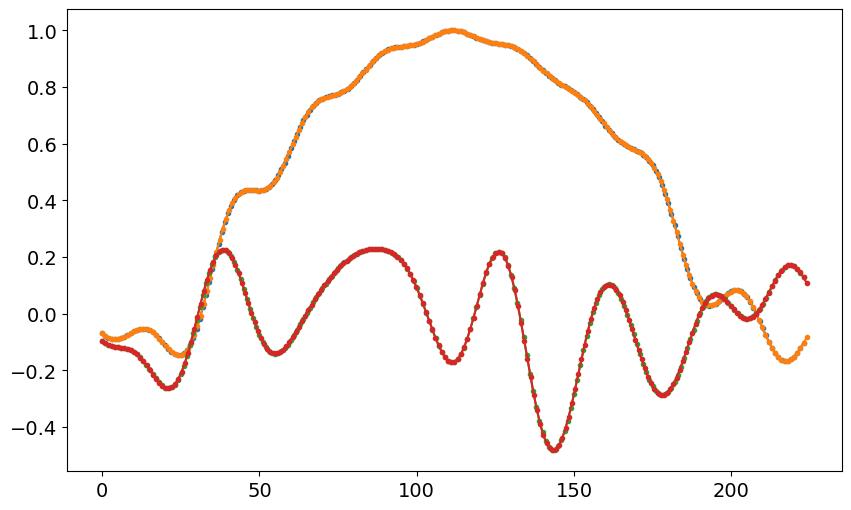

In [177]:
ch = 1
I_mhz_vs_us = I_values_MHz[0]
Q_mhz_vs_us = Q_values_MHz[0]
gencfg = soc['gens'][ch]
maxv = gencfg['maxv']*gencfg['maxv_scale']
samps_per_clk = gencfg['samps_per_clk']
times_cycles = np.linspace(0, soc.us2cycles(times_us[-1], gen_ch=ch), len(times_us))
times_samps = samps_per_clk * times_cycles
print(times_cycles)
print('samps per clock', samps_per_clk)
IQ_scale = max((np.max(np.abs(I_mhz_vs_us)), np.max(np.abs(Q_mhz_vs_us))))
I_func = sp.interpolate.interp1d(times_samps, I_mhz_vs_us/IQ_scale, kind='quadratic', fill_value='extrapolate')
Q_func = sp.interpolate.interp1d(times_samps, Q_mhz_vs_us/IQ_scale, kind='quadratic', fill_value='extrapolate')
print(times_samps[-1])
t = np.arange(0, np.round(times_samps[-1]))
iamps = I_func(t)
qamps = Q_func(t)
plt.plot(iamps, '.-')
plt.plot(times_samps, I_func(times_samps), '.-')
plt.plot(qamps, '.-')
plt.plot(times_samps, Q_func(times_samps), '.-')
plt.show()

Run amplitude rabi

In [26]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)

# span = 1500
# span = 3000
span = 32000
npts = 101
    
amprabi.cfg.expt = dict(
    # start=0, # qubit gain [dac level]
    # start=2047,
    start=100,
    step=int(span/npts), # [dac level]
    # step=0, # [dac level]
    expts=npts,
    reps=100,
    rounds=10,
    # sigma_test=0.100, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    # qubits=[1, 0], # qZZ, qTest
    qubits=[qubit_i],
    pulse_type='gauss',
    # pulse_type='adiabatic',
    # mu=6, # dimensionless
    # beta=4, # dimensionless
    # sigma_test=0.120*4, # us
    # pulse_type='pulseiq',
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# amprabi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(amprabi.cfg)

import Pyro4.util
try:
    amprabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3445.5877321124563, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.2353064588515, 0, 4766.264226603061, 4384.890337223246], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5892.7, 5152], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [29572, 24945, 2705, 2516], 'sigma': [0.02, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107, 18

  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 21048
	Pi/2 gain from amps data [dac units]: 10524
Pi gain from avgi data [dac units]: 20815
	Pi/2 gain from avgi data [dac units]: 10407
Pi gain from avgq data [dac units]: 21052
	Pi/2 gain from avgq data [dac units]: 10526


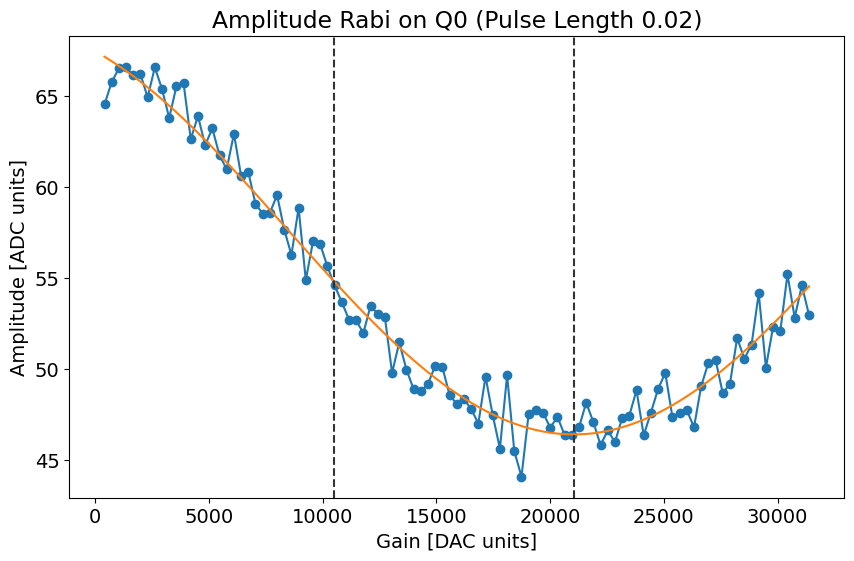

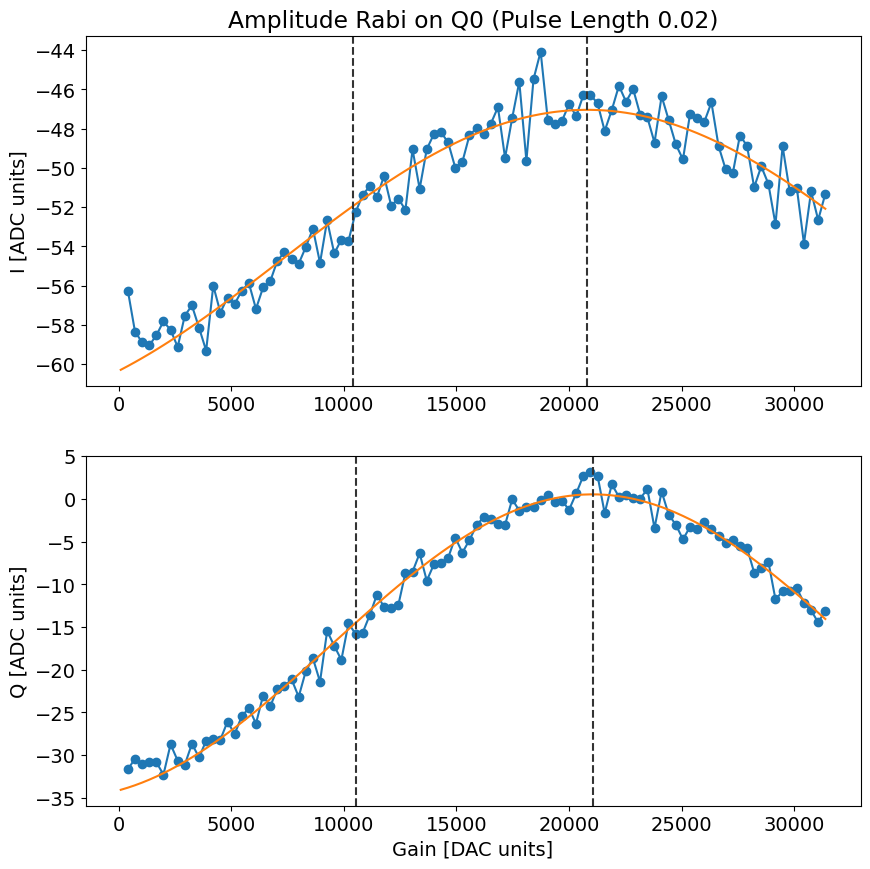

In [27]:
# # TESTING
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit2.h5')
# data = amprabi.analyze(data=temp_data, fit=True)
# amprabi.display(data=data, fit=True)

amprabi.analyze(fit=True)
amprabi.display(fit=True)

In [71]:
amprabi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220801\00000_amp_rabi_qubit1.h5


## Amplitude rabi qubit frequency sweep (chevron)

In [63]:
amprabichev = meas.AmplitudeRabiChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit_chevron{qubit_i}",
    config_file=config_path,
)

# span_gain = 32000
# npts_gain = 51
span_gain = 0
npts_gain = 1

span_f = 50
npts_f = 300

amprabichev.cfg.expt = dict(
    start_f=amprabichev.cfg.device.qubit.f_ge[qubit_i]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_Q1_ZZ[0]-span_f/2,
    # start_f=amprabichev.cfg.device.qubit.f_ef[qubit_i]-span_f/2,
    step_f=span_f/(npts_f-1),
    expts_f=npts_f,
    # start_gain=0, # qubit gain [dac level]
    start_gain=28000,
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    reps=50,
    rounds=10,
    # sigma_test=0.2, # gaussian sigma for pulse length - overrides config [us]
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
    # pulse_type='gauss',
    pulse_type='adiabatic',
    mu=6, # dimensionless
    beta=4, # dimensionless
    sigma_test=0.120*4, # us
)

# amprabichev.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

print(amprabichev.cfg)

amprabichev.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.6082793015007, 0, 3462.660233985849, 3462.4180842997853], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.5, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 19375, 8131, 5854], 'sigma': [0.03157, 0.045, 0.07, 0.07043], 'type': 'gauss'}, 'pi_ge_adiabatic': {'gain': [-1, 25000, -1, -1], 'mu': [0, 6, 0, 0], 'beta': [0, 4, 0, 0], 'period': [0, 0.48, 0, 0]}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.021

  0%|          | 0/300 [00:00<?, ?it/s]

s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\amplitude_rabi.py:472: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(
s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\amplitude_rabi.py:483: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(


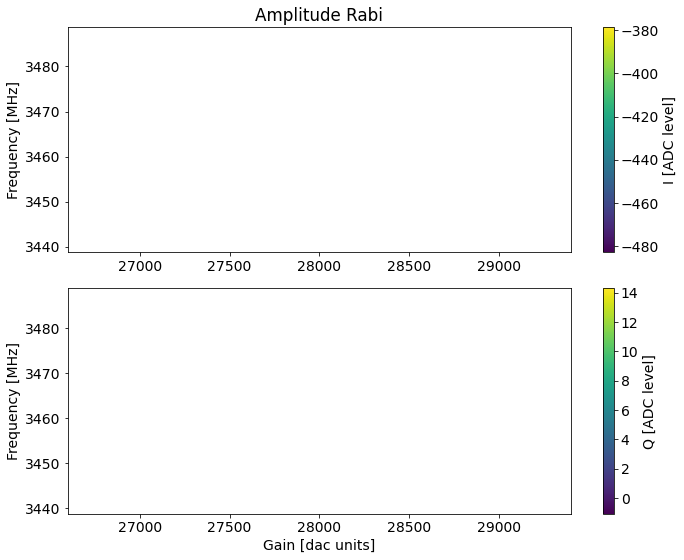

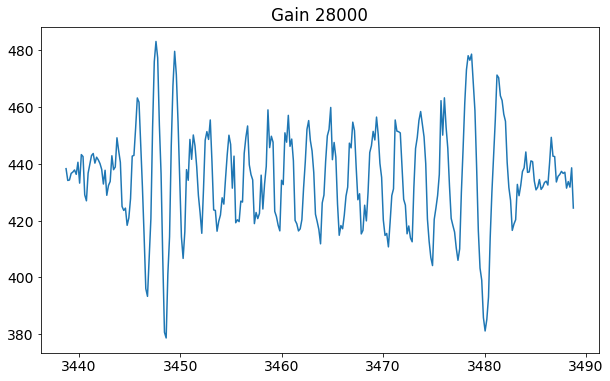

In [65]:
# # TESTING
# temp_data_file = '/home/xilinx/jupyter_notebooks/_experiment/20211215_LL_StandardCandle1/data/00000_power_sweep_resonator_spectroscopy_qubit2.h5'
# with SlabFile(temp_data_file) as a:
#     temp_data = dict(
#         amps=np.asarray(a['amps']),
#         gainpts=np.asarray(a['gain']),
#         fpts=np.asarray(a['freq']),
#     )

# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

amprabichev.analyze()
amprabichev.display()

In [ ]:
amprabichev.save_data()

## Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). The two output parameters should be stored in <code>cfg.device.readouti.phase</code> and <code>cfg.device.readouti.threshold</code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. Every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [90]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

shot.cfg.expt = dict(
    reps=10000,
    check_f=False,
    # qubit=1,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency[qubit_i]=-813.408 + 0.05
# shot.cfg.device.readout.gain[qubit_i]=0.1
# shot.cfg.device.readout.readout_length = 3 # [us]
shot.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]

shot.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Unrotated:
Ig -17.914443721535456 +/- 18.350609228276102 	 Qg -46.17664281067013 +/- 18.6121509009918 	 Amp g 49.52988628208502
Ie -40.6024723487313 +/- 20.887690807956215 	 Qe -67.59824333116461 +/- 20.40220083180713 	 Amp e 78.85482396333677
Rotated:
Ig 44.810144790732515 +/- 18.350609228276102 	 Qg 21.212559399272486 +/- 18.6121509009918 	 Amp g 49.577431886233036
Ie 76.3989240504328 +/- 20.887690807956215 	 Qe 21.29801686287925 +/- 20.40220083180713 	 Amp e 79.31204901120188


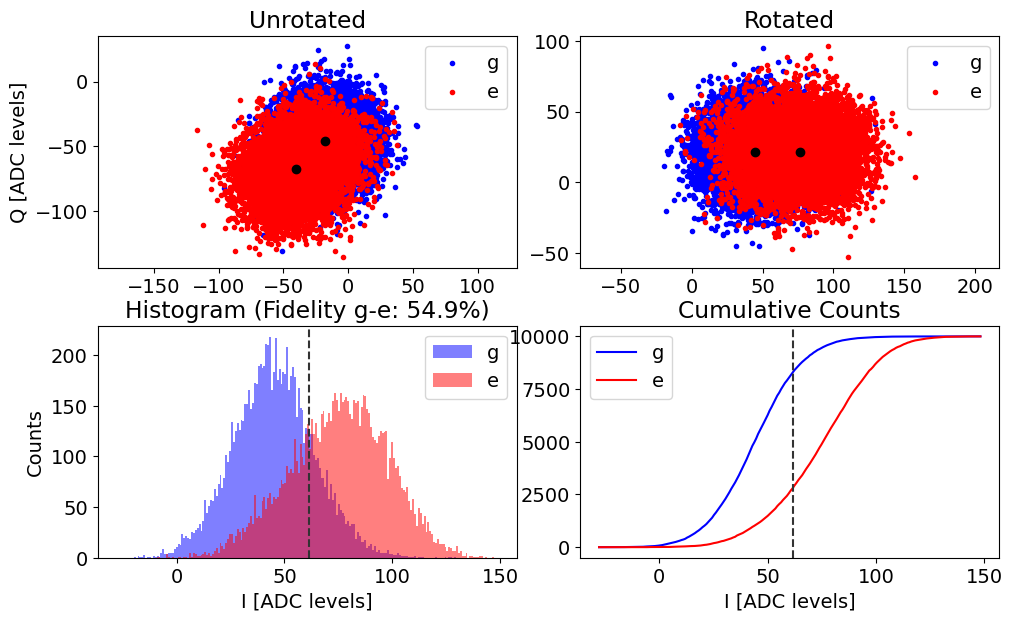

ge fidelity (%): 54.88548854885489
rotation angle (deg): 136.6445628556796
threshold ge: 61.488726511664225


In [91]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True, plot_f=False)

In [ ]:
# Checking for drift vs. shot number

data = shot.data
i = data['Ig']
q = data['Qg']
amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

plt.plot(amps, label='amps')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(phases, label='phases')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

In [126]:
shot.save_data()

Single shot drift

In [390]:
import time

Igs = []
Qgs = []
Ies = []
Qes = []
angles = []

drift_meas_time = 10*60

start_time = time.time()
elapsed_time = 0
meas_times = []
for i in tqdm(range(20)):
# for i in tqdm(range(3)):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )

    # shot.cfg.device.readout.frequency=-82.015-0.54
    shot.cfg.device.readout.gain=0.75
    # shot.cfg.device.readout.readout_length = 10 # [us]
    # shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
    # print(shot.cfg)

    shot.go(analyze=False, display=False, progress=False, save=False)
    elapsed_time = time.time() - start_time

    shot.analyze(verbose=False)

    Ig = np.average(shot.data['Ig'])
    Qg = np.average(shot.data['Qg'])
    Ie = np.average(shot.data['Ie'])
    Qe = np.average(shot.data['Qe'])
    angle = shot.data['angle']
    # print('Ig', Ig, 'Qg', Qg, 'Ie', Ie, 'Qe', Qe, 'angle', angle)

    Igs.append(Ig)
    Qgs.append(Qg)
    Ies.append(Ie)
    Qes.append(Qe)
    angles.append(angle)

    meas_times.append(elapsed_time)
    if elapsed_time > drift_meas_time: break
    time.sleep(30)

    

 45%|████▌     | 9/20 [10:56<13:22, 72.95s/it]


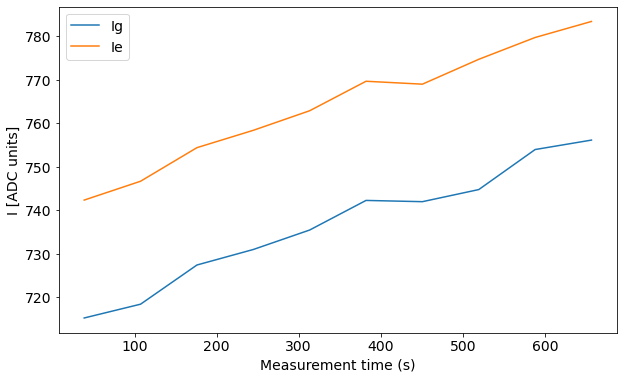

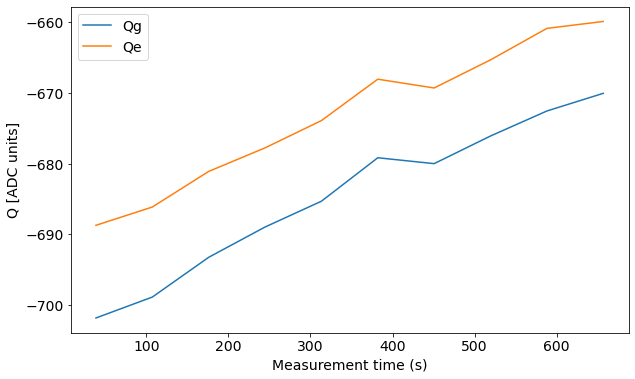

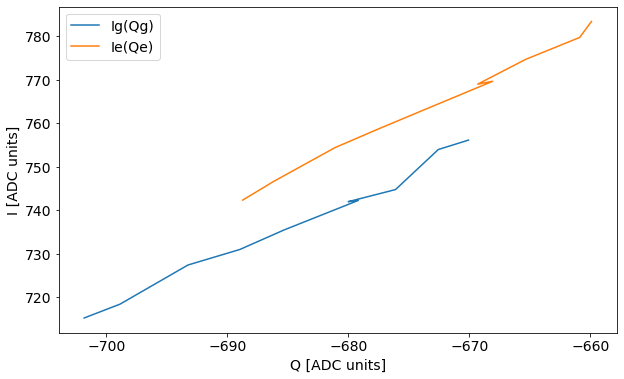

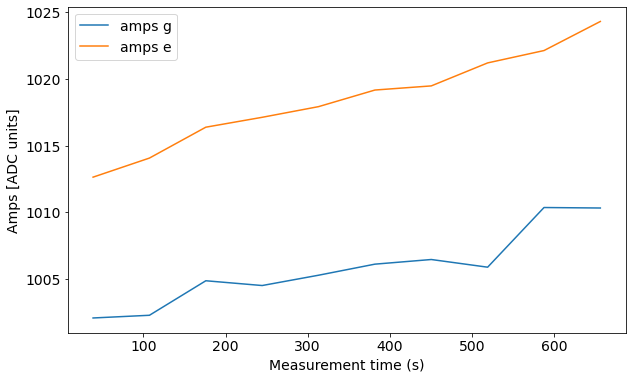

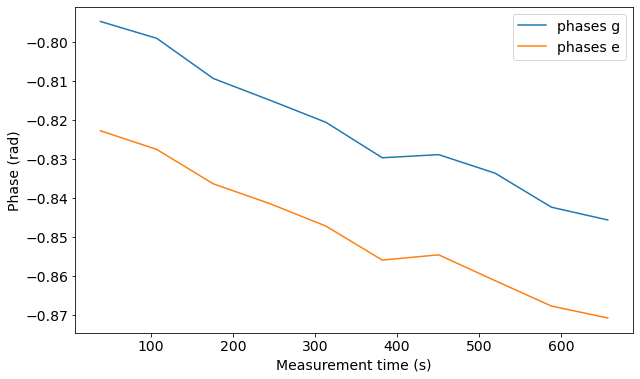

In [391]:
Igs = np.array(Igs)
Qgs = np.array(Qgs)
Ies = np.array(Ies)
Qes = np.array(Qes)
phase_gs = arctan(Igs/Qgs)
phase_es = arctan(Ies/Qes)
amps_gs = np.sqrt(Igs**2 + Qgs**2)
amps_es = np.sqrt(Ies**2 + Qes**2)

plt.plot(meas_times, Igs, label='Ig')
plt.plot(meas_times, Ies, label='Ie')
plt.ylabel('I [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, Qgs, label='Qg')
plt.plot(meas_times, Qes, label='Qe')
plt.ylabel('Q [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(Qgs, Igs, label='Ig(Qg)')
plt.plot(Qes, Ies, label='Ie(Qe)')
plt.ylabel('I [ADC units]')
plt.xlabel('Q [ADC units]')
plt.legend()
plt.show()

plt.plot(meas_times, amps_gs, label='amps g')
plt.plot(meas_times, amps_es, label='amps e')
plt.ylabel('Amps [ADC units]')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()

plt.plot(meas_times, phase_gs, label='phases g')
plt.plot(meas_times, phase_es, label='phases e')
plt.ylabel('Phase (rad)')
plt.xlabel('Measurement time (s)')
plt.legend()
plt.show()


### Single shot/readout optimization

In [57]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 1 # MHz
npts_f = 5

span_gain = 0.07
# npts_gain = 2
npts_gain = 7

span_len = 9 # us
# npts_len = 2
npts_len = 3

shotopt.cfg.expt = dict(
    reps=100000,
    qubit=qubit_i,

    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.5*span_f,
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 456.7], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2013, -1, 2682, 2385.8], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 15419, 13869, 7000], 'sigma': [0.035, 0.025, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 10922, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 7800, 10000], 'sigma': [0.1, 0, 0.17, 0.253], 'type': 'const'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.0555447534924, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 126.826, 0], 'threshold_ge': [0, 0, 5.5435, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': [200, 300, 150, 50]}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'i

  0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
shotopt.analyze()
print(shotopt.data['fid'])

(4, 6, 2)
[-805.55554475 -805.35554475 -805.15554475 -804.95554475 -804.75554475]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07]
[3. 6. 9.]
Max fidelity 0.14115141151411514
Set params: 
 angle (deg) 79.27975364474388 
 threshold -74.77681231100001 
 freq [Mhz] -804.7555447534925 
 gain [dac units] 0.06999999999999999 
 readout length [us] 9.0
[[[0.00840008 0.01332007 0.00761008]
  [0.0196801  0.0201102  0.02307012]
  [0.03011015 0.02903029 0.02637013]
  [0.03112016 0.03297016 0.03285016]
  [0.03341017 0.03753019 0.04184021]
  [0.03855039 0.03842019 0.03890039]
  [0.04129021 0.04111021 0.03618018]]

 [[0.03064015 0.03299016 0.03118016]
  [0.03923039 0.04150042 0.04435044]
  [0.04181042 0.04555023 0.04756024]
  [0.04568023 0.05172026 0.04778024]
  [0.05450027 0.06252031 0.05771087]
  [0.0604203  0.05873059 0.06262031]
  [0.06284031 0.05775029 0.06450032]]

 [[0.04171021 0.04239021 0.04251021]
  [0.07371074 0.08122081 0.08335083]
  [0.06460032 0.06747034 0.06370032]
  [0.05880029 0.05490027 0.05565

In [59]:
shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00001_single_shot_opt_qubit1.h5


## $T_1$

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [12]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)

span = 300
npts = 100

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    rounds=10,
    qubit=qubit_i,
)

t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]

print(t1.cfg)

t1.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.338723559245, 4782.994651953712, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4588.124531178372, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.8, 5168.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1628, 1770], 

  0%|          | 0/10 [00:00<?, ?it/s]

Fit T1 avgi [us]: 224.53141061081405
Fit T1 avgq [us]: 53.77139344222489


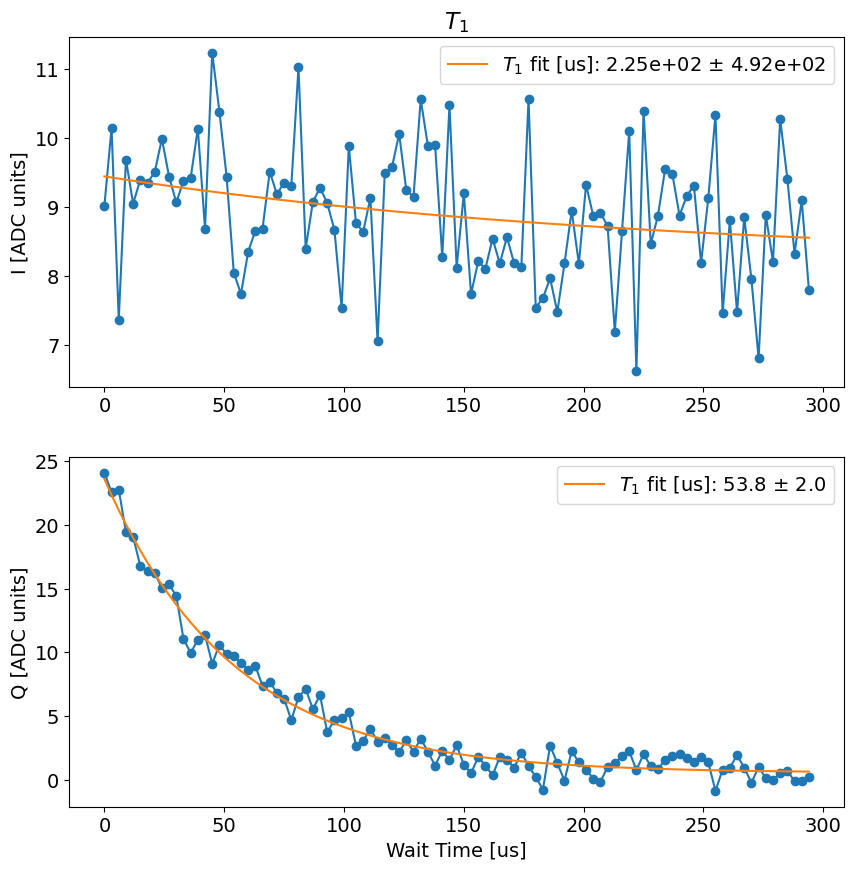

In [13]:
# # TESTING
# t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# data = t1.analyze(data=temp_data, fit=True)
# t1.display(data=data, fit=True)

t1.analyze(fit=True)
t1.display()

In [382]:
t1.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00001_t1_qubit3.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230217\\00001_t1_qubit3.h5'

## $T_2$ Ramsey Fringe Experiment

Measures the qubit $T_2$ Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse (about X-axis) followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse (about X-axis) with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency.

When qubit frequency is off by $\Delta$, oscillations will be observed at $\omega+\Delta$. Iterate on this experiment, adjusting the qubit frequency, until no oscillations are observed.

This exponential decay envelope can be fitted in post-processing to obtain the qubit $T_2$ Ramsey time.

In [12]:
0.5/soc.cycles2us(50)

4.3008

In [15]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)

t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=200,
    ramsey_freq=1.0, # [MHz]
    reps=100,
    rounds=20,
    # qubits=[qubit_i],
    qubits=[1, 0], # qZZ, qTest
    checkZZ=True,
    checkEF=False,
)
# t2r.cfg.device.readout.gain = 0.15
# t2r.cfg.device.readout.relax_delay = 3*t2r.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]
# t2r.cfg.device.qubit.pulses.pi_ge.gain = 4657
# t2r.cfg.device.qubit.pulses.pi_ge.sigma = 0.070

print(t2r.cfg)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'qubit': {'f_ge': [4114.583845316948, 3450.7895590725893, 4767.359704214145, 4386.191282153509], 'f_ef': [3887.2240728229826, 3350.330233073566, 4577.689960511519, 4213.394642821962], 'f_Q1_ZZ': [3445.5877321124563, 0, 3449.6936121756476, 3449.4923401580063], 'f_Q_ZZ1': [4109.221388203934, 0, 4766.264226603061, 4384.890337223246], 'f_EgGf': [2686.53594683, -1, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [-1, -1, 5892.7, 5152], 'gs': [53.07454288679892, 56.33900830945526, 44.06651851927302, 4.826787539590175, 2.201102542443888, 6.280490149923522], 'ZZs': [0.0, -5.132149880358156, -0.11720448229698377, -0.46755316331291397, -5.132149880358156, 0.0, -1.1258892837849999, -1.2798980910865794, -0.17297849, -1.1258892837849999, 0.0, -0.5808573560734658, -0.46704822, -1.2798980910865794, -0.4730200905169113, 0.0], 'T1': [10, 88, 33, 75], 'pulses': {'pi_ge': {'gain': [29572, 24945, 2705, 2516], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20819, 29107, 18

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 4.1062914572864315, which is out of bounds 0.02172121212121212 to 3.258181818181818. Instead init to 1.639951515151515
Current pi pulse frequency: 4109.221388203934
Fit frequency from amps [MHz]: 0.9835451451147167 +/- 0.004566940274736682
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4109.23784305882
 	4107.23784305882
T2 Ramsey from fit amps [us]: 3.5431172394567287
Current pi pulse frequency: 4109.221388203934
Fit frequency from I [MHz]: 0.9811462379944823 +/- 0.0055912014207395635
Suggested new pi pulse frequency from fit I [MHz]:
 	4109.240241965939
 	4107.240241965939
T2 Ramsey from fit I [us]: 2.926023840167131
Fit frequency from Q [MHz]: 0.9860817450825452 +/- 0.004491154308616251
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4109.2353064588515
 	4107.2353064588515
T2 Ramsey from fit Q [us]: 3.0969892053301282


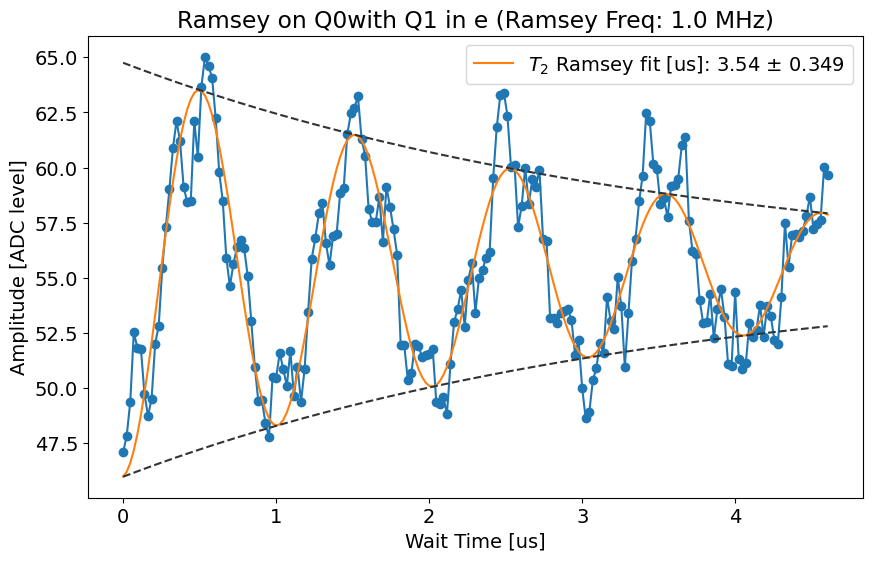

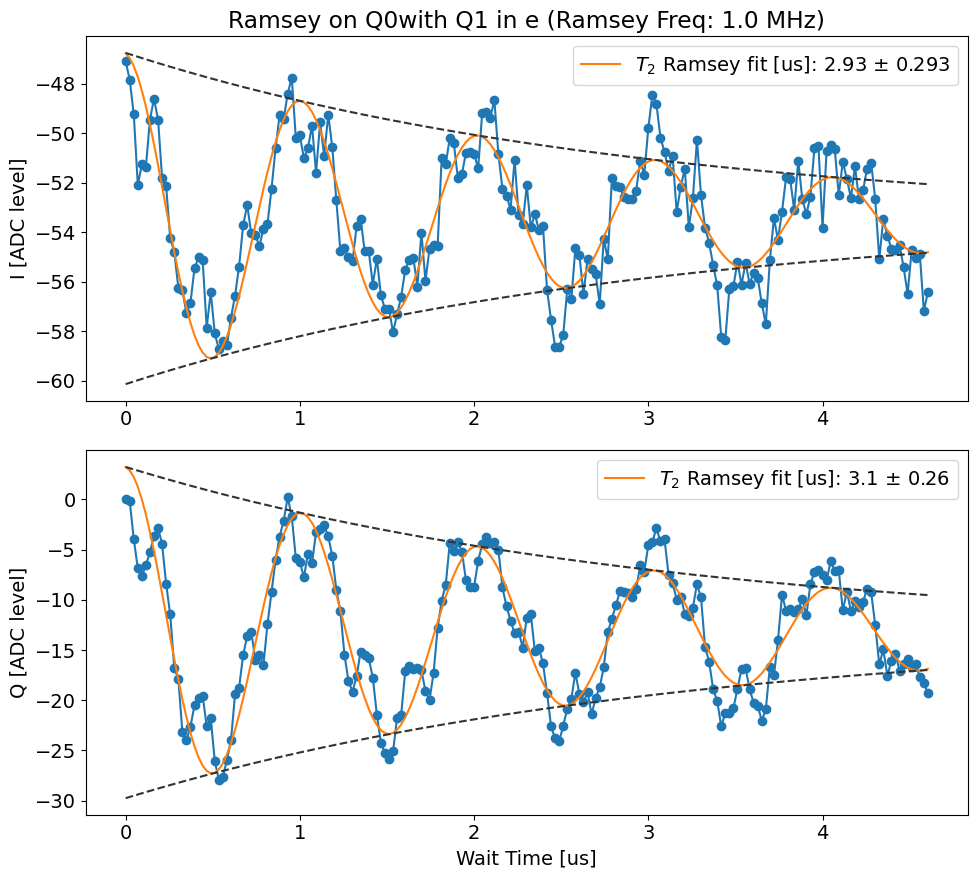

In [16]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.analyze(fit=True, fit_twofreq=False)
t2r.display(fit=True, fit_twofreq=False)

In [46]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230927\00002_ramsey_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_230927\\00002_ramsey_qubit0.h5'

## $T_2$ Echo

Same idea as Ramsey, but add additional $\pi$ pulses in the middle of $\tau$  which prevent the qubit from decaying as quickly.

In [166]:
0.5/soc.cycles2us(10)

17.499825

In [203]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(40), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=1.0, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

t2e.cfg.device.readout.relax_delay = 3*t2e.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(t2e.cfg)

t2e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [49, 65, 47, 80], 'f_ge': [4131.202186954483, 3456.77, 4785.262727180726, 4398.1923040581505], 'f_Q1_ZZ': [3451.633932698006, 3456.8876384119144, 3455.738449601716, 3455.698976070442], 'f_ef': [3906.0010603323535, 3354.1797149824265, 4595.697701845466, 4225.654774294284], 'f_EgGf': [2681.44696031, 3355.76150886, 2027.38642009, 2414.45684321], 'gs': [54.98834995, 55.21613685, 44.21773961, 7.06638874, 2.63846655, 6.19737439], 'ZZs': [0.0, -5.203507913231988, -0.22925396, -0.58692004, -5.253705713908403, 0.0, -1.0317205458959506, -1.2935543279095327, -0.22925396, -1.0891525267425095, 0.0, -0.49538999, -0.58692004, -1.2561113673027648, -0.49538999, 0.0], 'pulses': {'pi_ge': {'gain': [24302, 1026, 20144, 21990], 'sigma': [0.01717, 0.013, 0.018, 0.018], 'type': 'gauss'}, 'pi_ge_adiabatic': {'gain': [-1, 25000, -1, -1], 'mu': [0, 6, 0, 0], 'beta': [0, 4, 0, 0], 'period': [0, 0.48, 0, 0]}, 'pi_ef': {'gain': [21300, 0, 19544, 19157], 'sigma': [0.015, 0.015, 0.015, 0.

  0%|          | 0/10 [00:00<?, ?it/s]

Current qubit frequency: 3456.77
Fit frequency from I [MHz]: 0.9910673585254318 +/- 0.004880643696738591
T2 Echo from fit I [us]: 6.586596768882795
Fit frequency from Q [MHz]: 0.9836037935523718 +/- 0.0046141311932358445
T2 Echo from fit Q [us]: 7.939608134122287


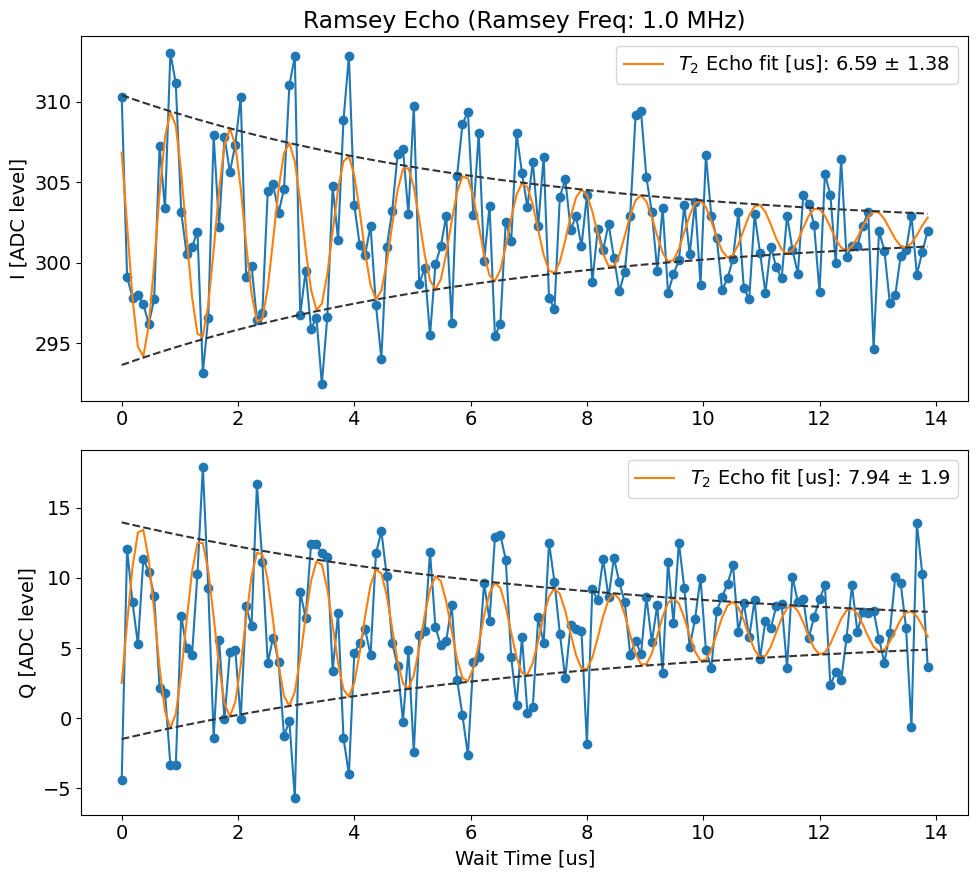

In [204]:
# # TESTING
# t2e = meas.RamseyEchoExperiment(config_file=config_path)
# t2e.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# data = t2e.analyze(data=temp_data, fit=True)
# t2e.display(data=data, fit=True)

t2e.analyze(fit=True)
t2e.display(fit=True)

In [316]:
t2e.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00000_echo_qubit0.h5


's:\\Connie\\experiments\\qramLL_4QR2\\data_220904\\00000_echo_qubit0.h5'

# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

Qubit ef frequency should be stored in <code>cfg.qubiti.f_ef</code>.

In [80]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span = 20
npts = 150

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    # start=qEFspec.cfg.device.qubit.f_ge[qubit_i] - 50 - span,
    # start=3435,
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=2000, # ef pulse gain
    pulse_type='gauss', # ef pulse type
    qubit=qubit_i,
)

# qEFspec.cfg.device.readout.relax_delay = 500 # Wait time between experiments [us]
# qEFspec.cfg.device.readout.gain = 0.75 # Wait time between experiments [us]
print(qEFspec.cfg)

qEFspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'f_ge': [4126.453954862341, 3454.211606121115, 4779.441948200766, 4394.480407282836], 'f_ef': [3900.453831863158, 3354.521139701014, 4590.177049031502, 4221.931929269591], 'f_Q1_ZZ': [3449.8479407210834, 0, 3453.9100412763405, 3453.7081320189013], 'f_Q_ZZ1': [4124.290504319941, 0, 4778.502356522805, 4393.211594838028], 'f_EgGf': [2681.44696031, -1, 2028.1, 2407.9], 'f_EgGf_Q': [-1, -1, 5913.75, 5163.75], 'gs': [54.233867058381975, 56.612917931142945, 42.87162116341841, 5.275712018852002, 2.7385639790041876, 6.807578931629736], 'ZZs': [0.0, -5.11947537, -0.14716401, -0.55347891, -5.11803281, 0.0, -1.17332055, -1.13249508, -0.17856354, -1.0686238, 0.0, -0.50772987, -0.64108991, -1.26309732, -0.62827282, 0.0], 'T1': [60, 60, 55, 50], 'pulses': {'pi_ge': {'gain': [28871, 26000, 2338, 2511], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_ef': {'gain': [20742, 26000, 1633, 1669], 'sigma': [0.015, 0.1, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [99

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3363.83629283752, HWHM -0.30935743192316306
Found peak in I at [MHz] 3354.443977214433, HWHM 1.9823349464028162
Found peak in Q at [MHz] 3358.202468648115, HWHM -0.0029265967512923144


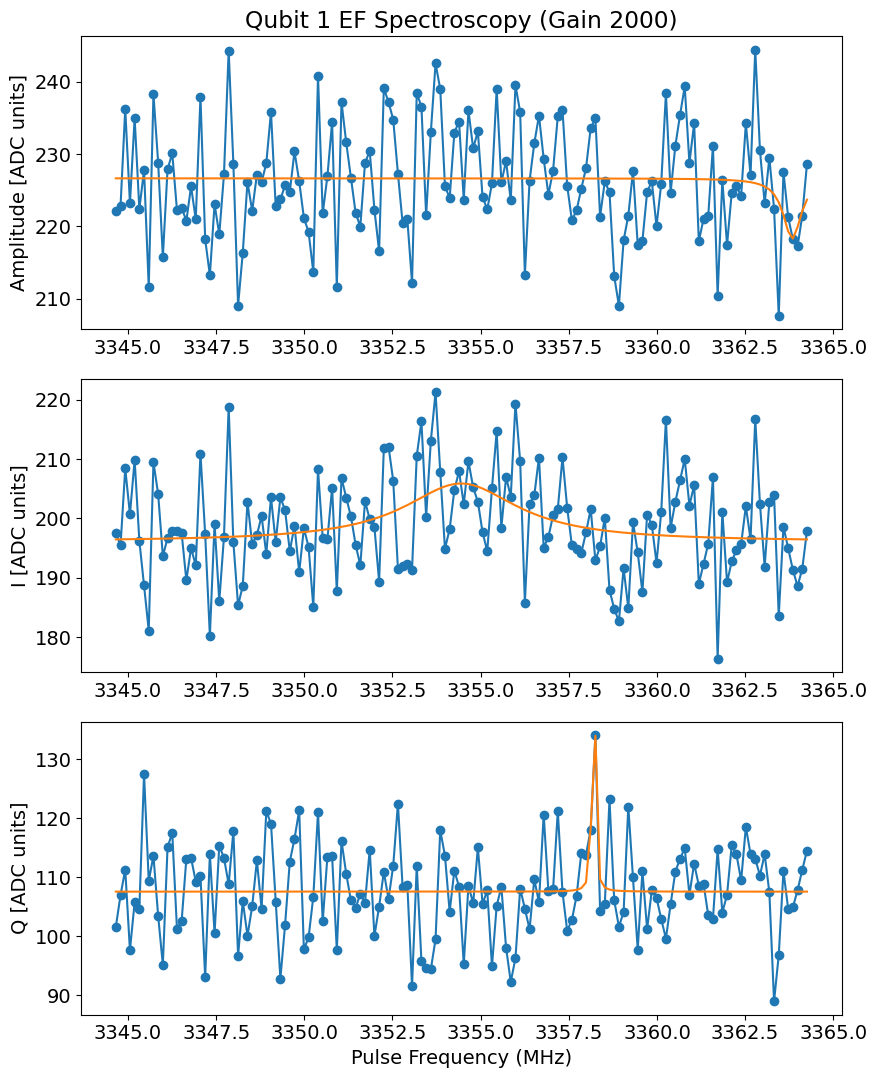

In [81]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

qEFspec.analyze(fit=True, signs=[1, -1, 1])
qEFspec.display(fit=True, signs=[1, -1, 1])

In [210]:
qEFspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00003_qubit_EF_spectroscopy_qubit3.h5


### Pulse probe EF power sweep

In [ ]:
pulseprobeEFpowspec = meas.PulseProbeEFPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_power_sweep_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 5
npts_f = 5

span_gain = 1000
npts_gain = 2

pulseprobeEFpowspec.cfg.expt = dict(
    start_f=pulseprobeEFpowspec.cfg.device.readout.frequency[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    # start_gain=pulseprobeEFpowspec.cfg.device.readout.gain[qubit_i], # Gain sweep start [DAC units]
    start_gain=1,
    step_gain=int(span_gain/npts_gain), # Gain step size
    expts_gain=npts_gain, # Number experiments stepping gain from start
    reps=10,
    rounds=10, # Number averages per point
    length=10, # ef const pulse length [us]
    qubit=qubit_i,
)
pulseprobeEFpowspec.cfg.device.readout.relax_delay = 2*pulseprobeEFpowspec.cfg.device.qubit.T1[qubit_i] # Wait time b/w expts [us]

print(pulseprobeEFpowspec.cfg)

pulseprobeEFpowspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

pulseprobeEFpowspec.analyze(lowgain=None, highgain=None)
pulseprobeEFpowspec.display()

## Length EF Rabi

In [230]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(1), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0,
    expts=101,
    reps=1000,
    gain=5, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/101 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 103.2192, which is out of bounds 0.43442424242424243 to 65.16363636363636. Instead init to 32.7990303030303
Attempted to init fitparam 1 to 103.2192, which is out of bounds 0.43442424242424243 to 65.16363636363636. Instead init to 32.7990303030303
Decay from avgi [us] 0.32796662339076715
Pi length from avgi data [us]: 0.037125695657721024
	Pi/2 length from avgi data [us]: 0.018562847828860512

Decay from avgq [us] 0.26565293074913116
Pi length from avgq data [us]: 0.037376930272217446
Pi/2 length from avgq data [us]: 0.018688465136108723


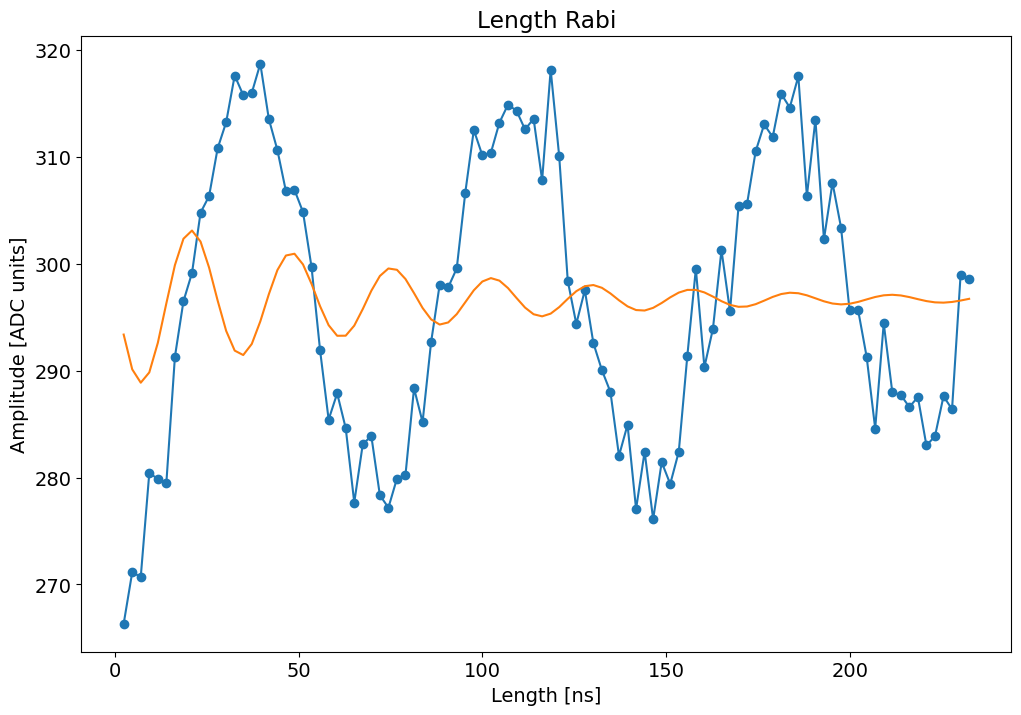

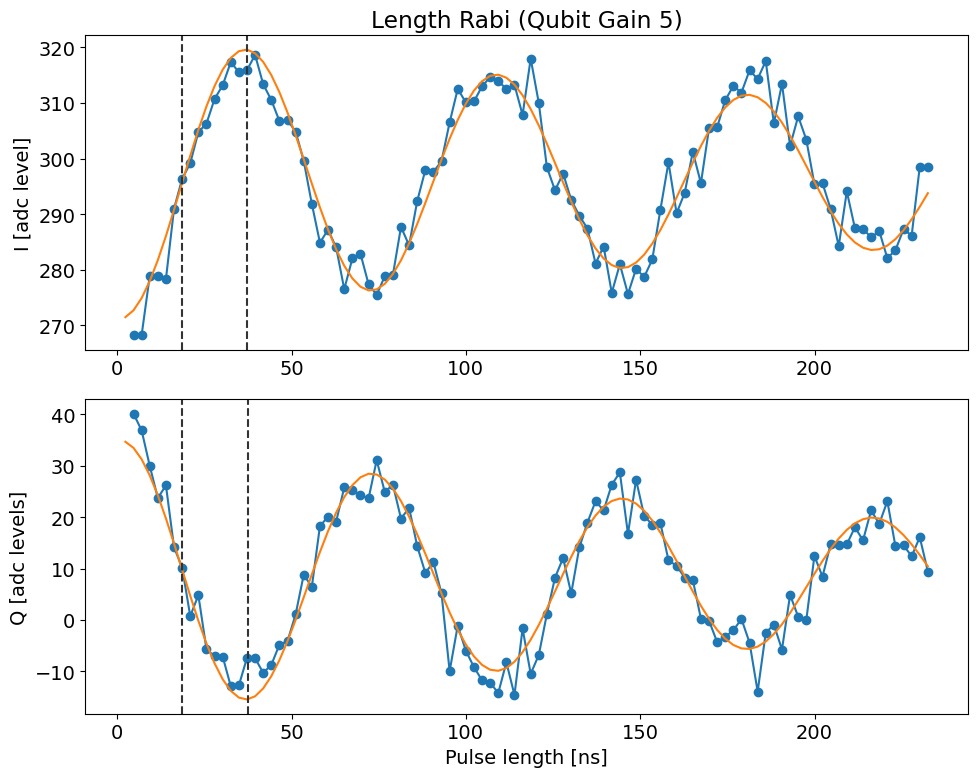

Use sigma 0.0336392372449957 for amplitude rabi EF


In [232]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Use sigma {pi_lenEF} for amplitude rabi EF')

In [ ]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [72]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

span = 4000
# span = 10000
npts = 101

amprabiEF.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=20,
    # sigma_test=0.013, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=True, # set to false when measuring qubit temp
    checkEF=True,
    checkZZ=False,
    pulse_type='gauss',
    qubits=[qubit_i],
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.338723559245, 4782.305489871236, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4592.511526938749, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.8, 5168.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1628, 1770], 

  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.012307692307692308, which is out of bounds 2.59000259000259e-05 to 0.00259000259000259. Instead init to 0.0013079513079513078
Pi gain from amps data [dac units]: 1637
	Pi/2 gain from amps data [dac units]: 818
Pi gain from avgi data [dac units]: 412
	Pi/2 gain from avgi data [dac units]: 206
Pi gain from avgq data [dac units]: 1633
	Pi/2 gain from avgq data [dac units]: 816


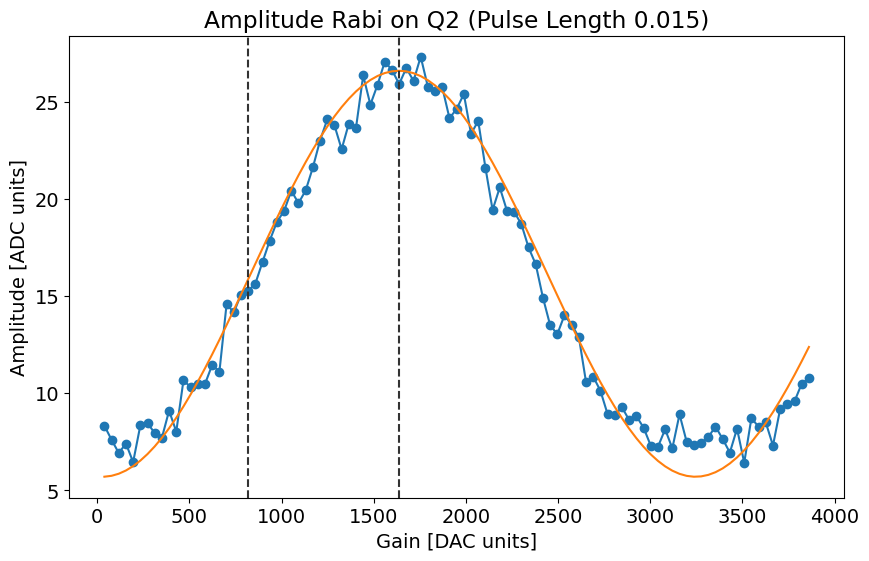

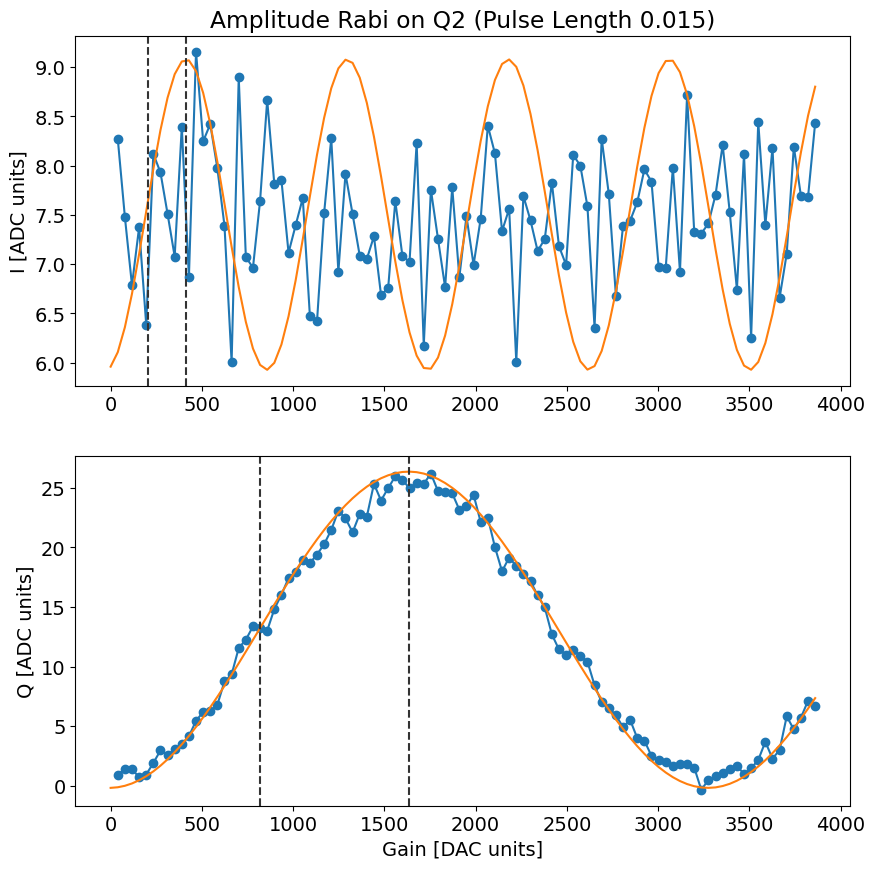

In [73]:
# # TESTING
# amprabiEF = meas.AmplitudeRabiEFExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# data = amprabiEF.analyze(data=temp_data, fit=True)
# amprabiEF.display(data=data, fit=True)

amprabiEF.analyze(fit=True)
amprabiEF.display(fit=True)

In [346]:
amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_amp_rabi_EF_qubit0.h5


### Qubit temperature
Run amplitude rabi EF twice, once with and once without pulse_ge. Input the amplitude of the rabi oscillation (printed in the cell below) for each of these cases to calculate qubit temperature from the ratio.

In [242]:
# NATRUAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(amprabiEF.cfg.device.qubit.f_ge[qubit_i] + amprabiEF.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

# print(amprabiEF.data.keys())
amps = amprabiEF.data['amps']
avgq = amprabiEF.data['avgq']

print(np.max(avgq) - np.min(avgq))
efamp_normal = 40
efamp_nopulse = abs(335-327)

print('Qubit temp [mK]:', 1e3*-h*fge/(kB*np.log(efamp_nopulse/efamp_normal)))


15.322239324928832
Qubit temp [mK]: 103.07902923184261


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [155]:
1/(soc.cycles2us(1)*151)

2.3178576158940403

In [18]:
t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(40), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=150,
    ramsey_freq=0.5, # [MHz]
    reps=200,
    rounds=10,
    qubit=qubit_i,
)

print(t2EFr.cfg)

t2EFr.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.2422590133906, 4782.305489871236, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4592.511526938749, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2022.3, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.8, 5166.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1633, 1770],

  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 5.339919463087248, which is out of bounds 0.007264864864864865 to 1.0897297297297297. Instead init to 0.5484972972972972
Current EF frequency: 4592.511526938749
Fit frequency from I [MHz]: 0.5363907587263216
Suggested new EF frequencies from fit avgi [MHz]:
 	4592.475136180023
 	4591.475136180023
T2 Ramsey EF from fit avgi [us]: 4.1294642857142865
Fit frequency from Q [MHz]: 0.5458507988081153
Suggested new EF frequencies from fit avgq [MHz]:
 	4592.465676139941
 	4591.465676139941
T2 Ramsey EF from fit avgq [us]: 9.248111585394811


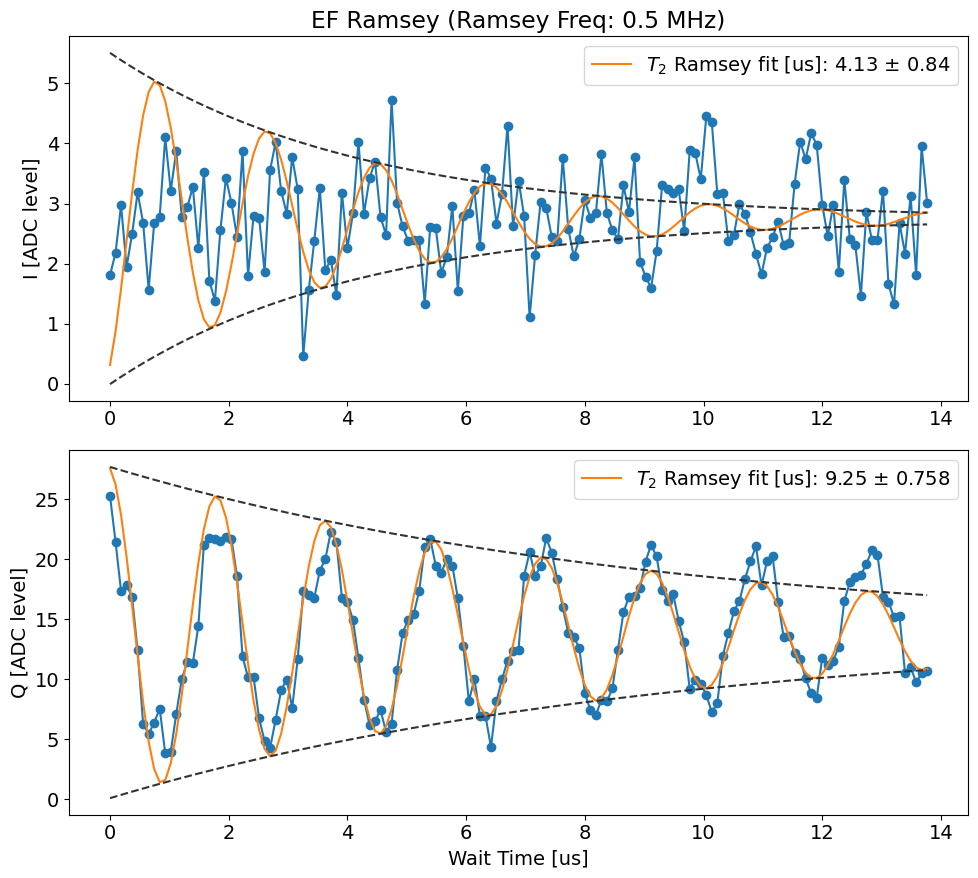

In [22]:
# # TESTING
# t2EFr = meas.RamseyEFExperiment(config_file=config_path)
# t2EFr.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data = prev_data(expt_path, '00000_ramseyEF_qubit0.h5')
# temp_data = temp_data[0]
# data = t2EFr.analyze(data=temp_data, fit=True)
# t2EFr.display(data=data, fit=True)

t2EFr.analyze(fit=True)
t2EFr.display(fit=True)

In [363]:
t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220904\00001_ramseyEF_qubit0.h5


# AC stark shift

Determine how much effective power is being applied for a drive detuned from qubit frequency

In [28]:
acspec = meas.ACStarkShiftPulseProbeExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ac_stark_shift_qubit{qubit_i}",
    config_file=config_path,
)

span_f = 50
npts_f = 150

span_gain = 30000
npts_gain = 5

pump_params=dict(
    ch=4,
    type='full',
    nyquist=1,
)

acspec.cfg.expt = dict(
    start_f=acspec.cfg.device.qubit.f_ge[qubit_i]-span_f/2, # Pulse frequency [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=1, # pump tone gain
    step_gain=int(span_gain/npts_gain),
    expts_gain=npts_gain,
    # pump_params=acspec.cfg.hw.soc.dacs.swap,
    pump_params=pump_params,
    # pump_freq=3300,
    pump_freq=acspec.cfg.device.qubit.f_EgGf[2],
    pump_length=12, # [us]
    qubit_gain=800,
    qubit_length=10, # [us]
    reps=1000,
    rounds=20, # Number averages per point
    qubit=qubit_i,
)
acspec.cfg.device.readout.relax_delay = 10
print(acspec.cfg)

acspec.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [70, 120, 40, 5], 'f_ge': [743.119, 3476.716, 166.5217, 449.757], 'f_ef': [649.12, 3376.34, -59.294, 295.9599], 'f_EgGf': [2105, -1, 2686.5343, 2403.299], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [27145, 13869, 13869, 10606], 'sigma': [0.035, 0.015, 0.02, 0.025], 'type': 'gauss'}, 'pi_ef': {'gain': [4713, 22501, 14543, 4728], 'sigma': [0.02, 0.025, 0.025, 0.025], 'type': 'gauss'}, 'pi_EgGf': {'gain': [1000, 0, 1000, 1000], 'sigma': [0.1, 0, 0.1, 0.1], 'type': 'gauss'}}}, 'readout': {'trig_offset': 120, 'frequency': [810.409984606071, -805.058197780235, -82.367068, 79.3372763161615], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.085, 0.03, 0.025, 0.07], 'phase': [0, 0, 0, 0], 'threshold_ge': [0, 0, 0, 0], 'threshold_ef': [1, 1, 1, 1], 'readout_length': [5, 5, 5, 5], 'relax_delay': 10}}, 'hw': {'lo': {'readout': {'frequency': '5925e6', 'power': 10}}, 'soc': {'dacs': {'qubit': {'ch': [0, 5, 0, 0], 'type': ['int4', 'full', 'int4', 'int4'], 'mixer_freq': [4

  0%|          | 0/5 [00:00<?, ?it/s]

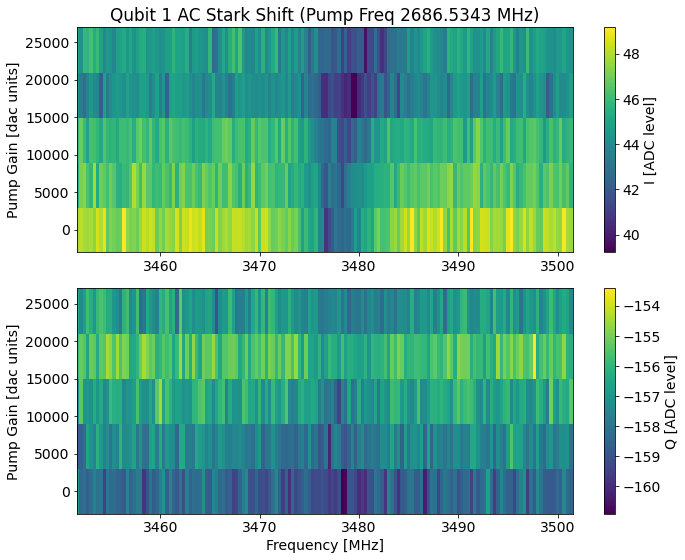

In [29]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = acspec.analyze(data=temp_data)

acspec.analyze()
acspec.display()

In [30]:
acspec.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_220712\00002_ac_stark_shift_qubit1.h5


# Single qubit RB

In [33]:
# qubit_i = 3
qubits = [3, 1]

{'device': {'qubit': {'T1': [45, 127, 55, 50], 'f_ge': [4128.575129385544, 3457.2422590133906, 4782.305489871236, 4396.915066710553], 'f_Q1_ZZ': [3452.0169427371175, 3457.338723559245, 3456.1893267454375, 3456.018803727748], 'f_Q_ZZ1': [4123.341754941294, 3457.338723559245, 0, 0], 'f_ef': [3902.5097729724093, 3356.7928599815136, 4592.465676139941, 4223.758894341571], 'f_EgGf': [2681.44696031, -1, 2028.5, 2407.9], 'f_EgGf_Q': [-1, -1, 5916.5, 5166.4], 'gs': [54.34474556, 56.18845266, 43.07411448, 5.80677427, 2.37708297, 6.56997134], 'ZZs': [0.0, -5.321780822127494, -0.15523394324009132, -0.5691491834904809, -5.321780822127494, 0.0, -1.1493968138074706, -1.319919831496918, -0.15523394324009132, -1.1493968138074706, 0.0, -1.2349280184125746, -0.6247231879115134, -1.319919831496918, -1.2349280184125746, 0.0], 'pulses': {'pi_ge': {'gain': [29539, 824, 2328, 2534], 'sigma': [0.015, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_ge_IQ': {'gain': 1373}, 'pi_ef': {'gain': [25302, 473, 1633, 1770],

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)


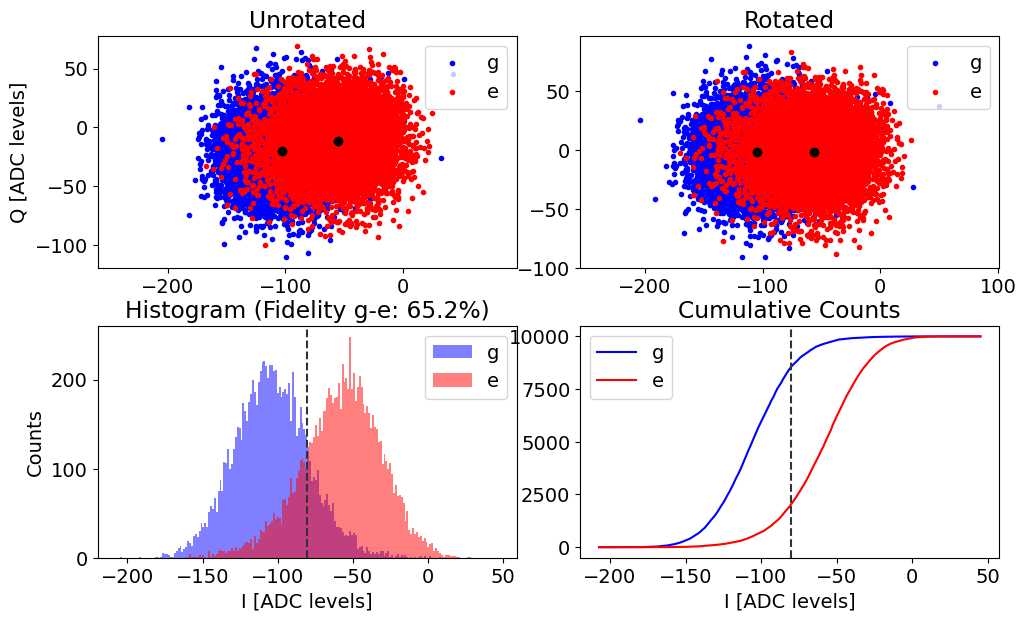

ge fidelity (%): 65.23326166308316 	 angle (deg): -10.09126907922383 	 threshold ge: -80.38343027701833
Qubit  (1)


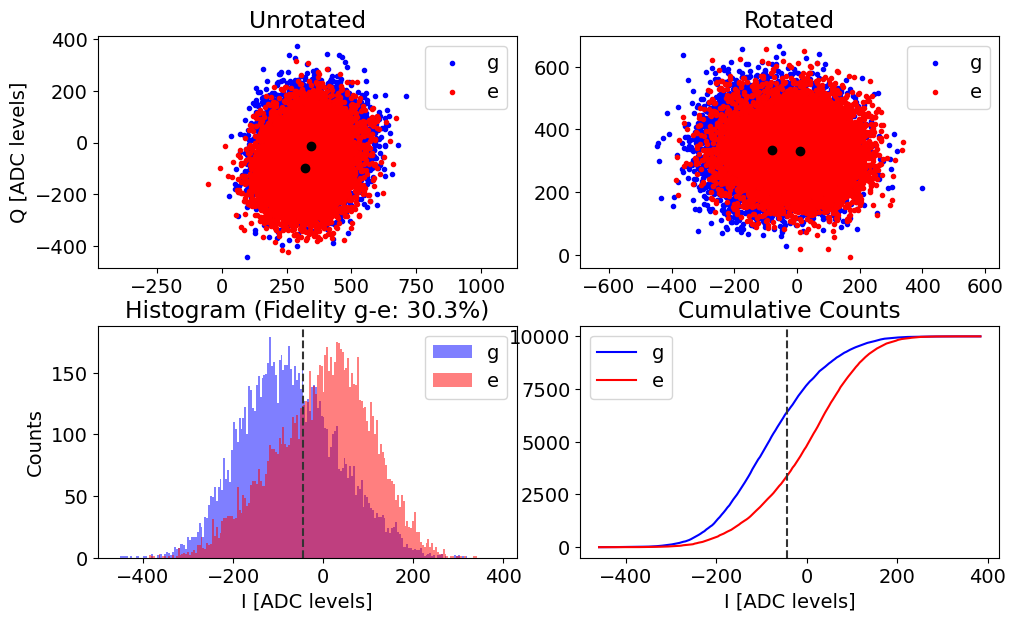

ge fidelity (%): 30.34151707585379 	 angle (deg): 105.61006859616839 	 threshold ge: -43.71112346297582


  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    step=8, # step rb depth
    expts=10, # number steps
    reps=1500, # number averages per unique sequence
    variations=30, # number different sequences per depth
    # gate_char='X', # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    use_EgGf_subspace=True, # specifies whether to run RB treating EgGf as the TLS subspace
    # qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    qubits=qubits,
    qDrive=qubits[0],
    singleshot_reps=10000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
)

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

[ 1  9 17 25 33 41 49 57 65 73] [0.98214666 0.82970777 0.76575148 0.71427463 0.68531801 0.74395723
 0.6833666  0.66898771 0.68983588 0.63463886]
[0.92660901 0.32893114 0.67318673]
0.00019449726073400068 0.0007750267189490789 0.00017122545382511754
[ 1  9 17 25 33 41 49 57 65 73] [0.76545113 0.5367573  0.44050192 0.3128885  0.26224466 0.31186479
 0.24846722 0.20877679 0.21028826 0.1356866 ]
Attempted to init fitparam 2 to -0.24606171690506073, which is out of bounds 0 to 0.8823617771111685. Instead init to 0.44118088855558424
[0.94917456 0.6086101  0.17658234]
7.43617488395627e-05 0.0015605080732767594 0.0007844064134391776
Running regular RB on EgGf subspace
Depolarizing parameter p from fit: 0.9266090062384614 +/- 0.013946227473191476
Average RB gate error: 0.0550432453211539 +/- 0.010459670604893606
	Fidelity=1-error: 0.9449567546788461 +/- 0.010459670604893606


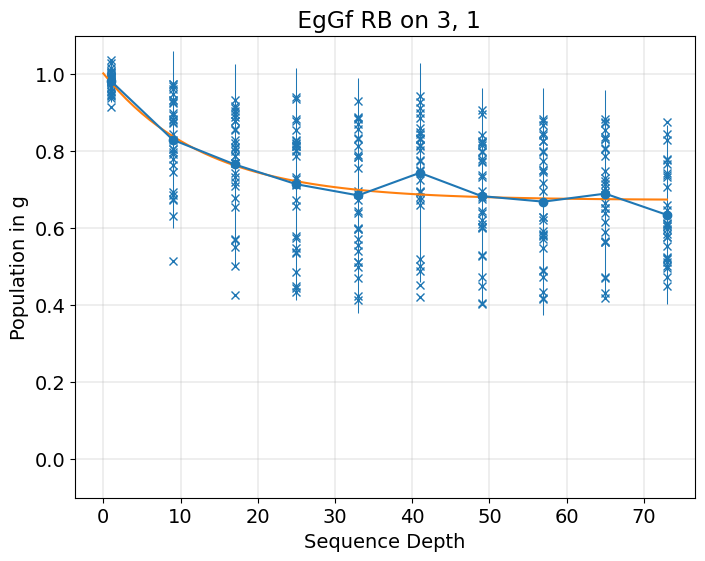

In [35]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=qubits)

In [264]:
p_irb = 0.954568577245045  
p_rb = 0.9623 
print(meas.fitting.rb_error(p_rb, 2))
print(meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2))

0.018850000000000033
0.995982841756752


In [411]:
rbprog.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_rb1Q_qubit0.h5


TypeError: Object dtype dtype('O') has no native HDF5 equivalent

# Repeat over time

In [45]:
import time

In [53]:
debug = False

start_time = time.time()

all_fids = []
all_T2R = []
all_T2R_err = []
times = []

if debug:
    max_time = 5*60
    print_time = 0
    wait_time = 0
else:
    max_time = 50*60*60
    print_time = 3*60*60
    wait_time = 10*60

time_of_last_print = time.time()
while time.time() - start_time < max_time:
    times.append(time.time()-start_time)

    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file=config_path,
    )

    shot.cfg.expt = dict(
        reps=20000,
        check_f=False,
        qubit=qubit_i,
    )
    shot.go(analyze=False, display=debug, progress=False, save=False)
    shot.analyze(verbose=False)
    all_fids.append(shot.data['fids'][0])


    t2r = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )

    t2r.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        expts=150,
        ramsey_freq=0.5, # [MHz]
        reps=100,
        rounds=20,
        qubits=[qubit_i],
        checkZZ=False,
        checkEF=False,
    )
    t2r.go(analyze=True, display=debug, progress=False, save=False)
    t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

    all_T2R.append(t2r_fit[3])
    all_T2R_err.append(np.sqrt(t2r_fit_err[3][3]))

    time.sleep(wait_time)

    if time.time() - time_of_last_print > print_time:
        print('all_fids =', all_fids)
        print('all_T2R =', all_T2R)
        print('all_T2R_err =', all_T2R_err)
        print('times =', times)
        time_of_last_print = time.time()


Attempted to init fitparam 1 to 2.3091543624161073, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 8.659328859060402, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 2.886442953020134, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 3.463731543624161, which is out of bounds 0.01452972972972973 to 2.1794594594594594. Instead init to 1.0969945945945945
Attempted to init fitparam 1 to 2.453476510067114, which is out of bounds 0.01452972972

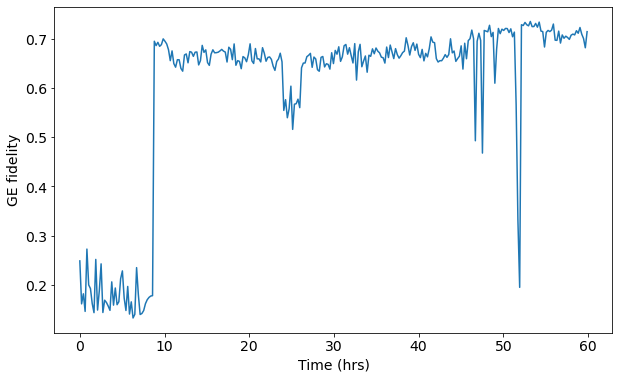

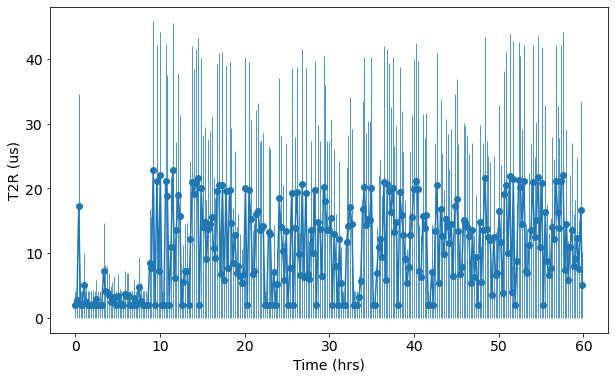

In [54]:
times = np.asarray(times)
plt.figure(figsize=(10, 6))
plt.plot(times/60/60, all_fids)
plt.xlabel('Time (hrs)')
plt.ylabel('GE fidelity')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(times/60/60, all_T2R, fmt='o-', yerr=all_T2R, color='tab:blue', elinewidth=0.75)
plt.xlabel('Time (hrs)')
plt.ylabel('T2R (us)')
plt.show()